In [1]:
import numpy as np
import pickle
import os
import sys
import data_process_utils as dpu

In [22]:
def process_annot_line(line):
    line = line.replace("DR","11").replace("DL","12")
    line = line.replace("PR","21").replace("PL","22")    
    line = line.replace("NR","31").replace("NL","32")
    line = line.replace("I","1").replace("Q","2")
    line = line.replace("C","-1").replace("S","-2").replace("M","-3").replace('X', '-100')    
    
    v = line.rstrip().split(',')    
    v = [float(x) for x in v]
    return v

In [ ]:
path = 'C:/ASM/PublicData/eating_steventech/lab'
data = []
for subj in range(7):
    dsubj = []
    asubj = []
    for sess in range(2):        
        if subj==1 and sess==1: continue            
            
        filePathAccel = path + "/0" + str(subj) + "/000" + str(sess) + "/watch_right_000" + str(sess) + ".csv"
        dr = np.genfromtxt(filePathAccel, delimiter=',')
        dr[:, 0] = dr[:, 0]/1e9        
        quat = dr[:, -3:]
        _ , _ , grav = dpu.quat2mat(quat)
        dr = np.concatenate((dr[:, :7], grav), axis=1)
        
        filePathAccel = path + "/0" + str(subj) + "/000" + str(sess) + "/watch_left_000" + str(sess) + ".csv"
        dl = np.genfromtxt(filePathAccel, delimiter=',')
        dl[:, 0] = dl[:, 0]/1e9        
        quat = dl[:, -3:]
        _ , _ , grav = dpu.quat2mat(quat)
        dl = np.concatenate((dl[:, :7], grav), axis=1)

        filePathAnnots = path + "/0" + str(subj) + "/000" + str(sess) + "/annot_events.csv"
        a = open(filePathAnnots).readlines()
        a = [process_annot_line(line) for line in a]
        a = np.array(a)
        
        print(subj, sess, dr.shape, dl.shape, a.shape, end=" | ")        
        dsubj.append({"data_right":dr, "data_left":dl, 'annots':a})
        
    data.append(dsubj)
    
with open('C:/ASM/DevData/eating_steven/data/raw_lab_data.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
total, bite, sip, repeat = 0, 0, 0, 0
hand_count = [0, 0, 0, 0]
for subj in range(7):
    for sess in range(len(data[subj])):        
        a = np.copy(data[subj][sess]["annots"])        
        acount = len(a)
        
        print(subj, sess, a.shape)
        print('---------------------------')
        
        for c in [1,2, 11, 12, 21, 22]:#[11, 12, 21, 22, 31, 32, 1, 2, -1, -2, -3, -100]:
            x = np.sum(a[:, 2]==c)
            if c==1:
                bite +=x
            elif c==2:
                sip+=x
            print(c," : ", x)
            total+=x
        
        oi = np.arange(acount)
        cond = (a[:, 2]>0) & (a[:, 2]<20)
        a = a[cond]
        oi = oi[cond]
        print(a.shape)
        
        acount = len(a)        
        for i in range(acount-1):
            if a[i, 2]==11 and a[i+1, 2]!=12 and a[i+1,2]!=1 and a[i+1,2]!=2:
                    print("Sequence Problem at ", i, oi[i])
                    
                
            elif a[i, 2]==12 and a[i+1, 2]!=11 and a[i+1,2]!=1 and a[i+1,2]!=2:    
                print("Left Sequence Problem at ", i, oi[i])
                
        i = 0
        hand = 0
        last_was_bite = True
        res = []        
        for i in range(acount):
            if a[i, 2]==11 or a[i, 2]==12:
                if last_was_bite:
                    hand = int(a[i, 2]-10)
                else:
                    print("Both hands at index:", oi[i], ", Time difference: ", a[i, 0]-a[i-1,0])
                    if a[i, 0]-a[i-1,0]>1:
                        print("$$$$$$$$$$$$$$$$$$$$$$ Both hand time problem $$$$$$$$$$$$$$$$$$$$$")
                    hand =3
                
                last_was_bite = False
                repeat_count = 0
                

            elif a[i, 2]==1 or a[i, 2]==2:
                if not last_was_bite:
                    hand_count[hand]+=1
                
                r = [a[i,0], a[i,1], a[i,2], hand, 0]                
                if hand==0:
                    print("***************No hand found**************", i, oi[i])
                elif last_was_bite:
                    repeat_count +=1
                    r[-1] = repeat_count
                    print("***************Bite/Sip repeated**************", i, int(a[i, 0]), "Bite/sip: ", int(a[i, 2]), " hand:", int(hand), r[-1])                    
                    repeat+=1
                    
                res.append(r)                
                last_was_bite = True
        
        print(repeat)
        
print("Total, bie, sip, repeat: ", total, bite, sip, repeat)

In [14]:
print(hand_count)
total = sum(hand_count)
print(total)
print(hand_count[1]/total, hand_count[2]/total, hand_count[3]/total)

[0, 1280, 243, 249]
1772
0.7223476297968398 0.1371331828442438 0.14051918735891647


In [ ]:
for subj in range(7):
    for sess in range(len(data[subj])):
        print(subj, sess)
        d = np.copy(data[subj][sess]["data_right"])
        #ix = 14827
        #df = d[ix+7000, 0]-d[ix+7001, 0]
        #d[ix:, 0] = d[ix:, 0] - d[ix, 0] + d[ix-1, 0] + (d[ix-1, 0]-d[ix-2, 0])

        for i in range(1, len(d)): 
            if d[i, 0] - d[i-1,0]>0.5: 
                print("right: ", i, d[i-1,0], d[i, 0], d[i,0]-d[i-1,0])  

        d = np.copy(data[subj][sess]["data_left"])
        #ix = 14827
        #df = d[ix+7000, 0]-d[ix+7001, 0]
        #d[ix:, 0] = d[ix:, 0] - d[ix, 0] + d[ix-1, 0] + (d[ix-1, 0]-d[ix-2, 0])

        for i in range(1, len(d)): 
            if d[i, 0] - d[i-1,0]>0.5: 
                print("left: ", i, d[i-1,0], d[i, 0], d[i,0]-d[i-1,0])  

In [17]:
subj, sess = 6, 0
dr = np.copy(data[subj][sess]["data_right"])
dl = np.copy(data[subj][sess]["data_left"])
a = np.copy(data[subj][sess]["annots"])
print(subj, sess, dr.shape, dl.shape, a.shape)
print('---------------------------')

io = np.arange(len(a))
cond = (a[:, 2]>0) & (a[:, 2]<30)
a = a[cond]
io = io[cond]
#print(a.shape)

i = 0        
last_was_bite = True
annots = []        
for i in range(len(a)):
    if a[i, 2]==21 or a[i, 2]==22:
        if last_was_bite:
            hand = a[i, 2]-20
        else:
            hand =3

        last_was_bite = False
        repeat_count = 0

    elif a[i, 2]==1 or a[i, 2]==2:
        r = [a[i,0], a[i,1], a[i,2], hand, 0]                
        if hand==0:
            print("***************No hand found**************", i, )
        if last_was_bite:
            repeat_count +=1
            r[-1] = repeat_count
            print("***************Bite/Sip repeated**************", i, int(a[i,0]), a[i, 2], int(hand), r[-1])                    
            repeat+=1

        annots.append(r)                
        last_was_bite = True

annots = np.array(annots)
print("Total: ", annots.shape)
bites = annots[annots[:, 2]==1]
print( "Bites: ", len(bites), np.sum(bites[:, 3]==1), np.sum(bites[:, 3]==2), np.sum(bites[:, 3]==3))

sips = annots[annots[:, 2]==2]
print( "Sips: ", len(sips), np.sum(sips[:, 3]==1), np.sum(sips[:, 3]==2), np.sum(sips[:, 3]==3))



6 0 (330052, 10) (329767, 10) (725, 3)
---------------------------
Total:  (48, 5)
Bites:  36 21 2 13
Sips:  12 0 12 0


In [18]:
if subj==0 and sess==0:
    ix = 14827
    df = dr[ix+7000, 0]-dr[ix+7001, 0]
    dr[ix:, 0] = dr[ix:, 0] - dr[ix, 0] + dr[ix-1, 0] + (dr[ix-1, 0]-dr[ix-2, 0])
    print(dr[ix, 0])

In [19]:
for i in range(annots.shape[0]):
    print(annots[i].astype(int))
    

[287   0   1   1   0]
[300   0   1   1   0]
[314   0   1   1   0]
[323   0   1   1   0]
[338   0   1   1   0]
[346   0   1   1   0]
[355   0   1   1   0]
[366   0   1   1   0]
[375   0   1   1   0]
[384   0   1   1   0]
[395   0   1   1   0]
[405   0   1   1   0]
[422   0   1   1   0]
[431   0   1   1   0]
[438   0   1   1   0]
[452   0   1   1   0]
[462   0   1   1   0]
[472   0   1   1   0]
[478   0   1   1   0]
[7019    0    1    3    0]
[7046    0    1    3    0]
[7071    0    1    3    0]
[7104    0    1    3    0]
[7131    0    1    3    0]
[7152    0    1    3    0]
[7180    0    1    1    0]
[7213    0    1    1    0]
[7252    1    2    2    0]
[7265    1    2    2    0]
[7283    0    1    3    0]
[7321    0    1    3    0]
[7347    0    1    3    0]
[7368    0    1    3    0]
[7402    0    1    3    0]
[7426    0    1    3    0]
[7448    0    1    3    0]
[7482    0    1    2    0]
[7514    0    1    2    0]
[7557    5    2    2    0]
[7567    1    2    2    0]
[7862    2    2

In [3]:
with open('C:/ASM/DevData/eating_steven/data/lab_data_steven.pkl', 'rb') as file:
    ds = pickle.load(file)


153
Index:0, Time: 569.2665, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
569.2665 0.0
320


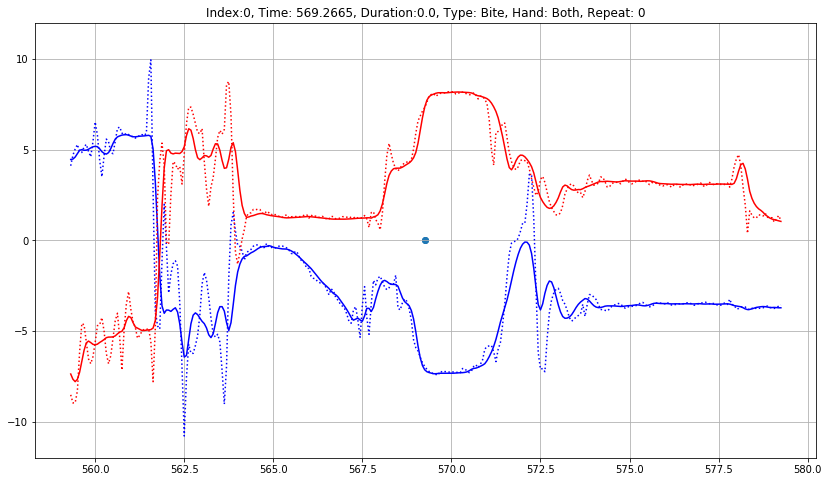

Index:1, Time: 580.817, Duration:1.516, Type: Sip, Hand: Left, Repeat: 0
580.817 1.516
344


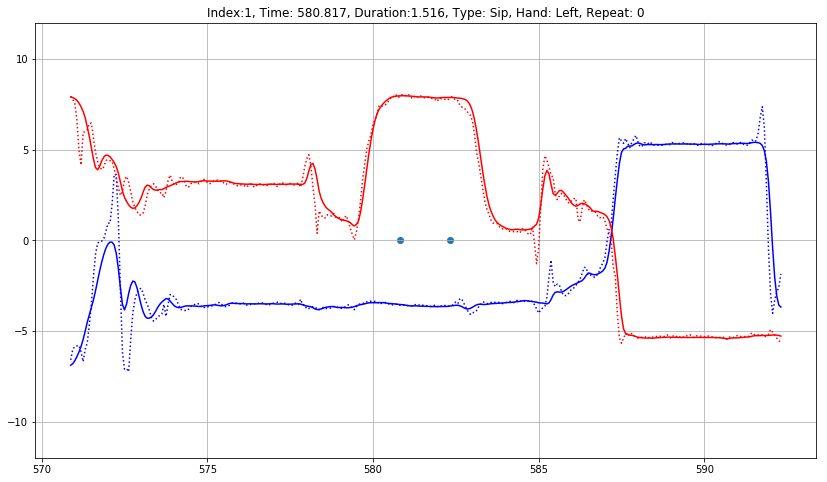

Index:2, Time: 594.583, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
594.583 0.0
320


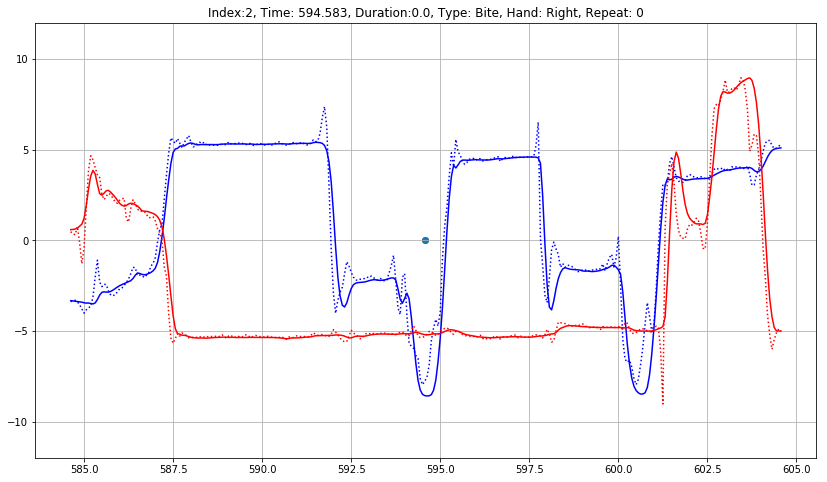

Index:3, Time: 600.5335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
600.5335 0.0
320


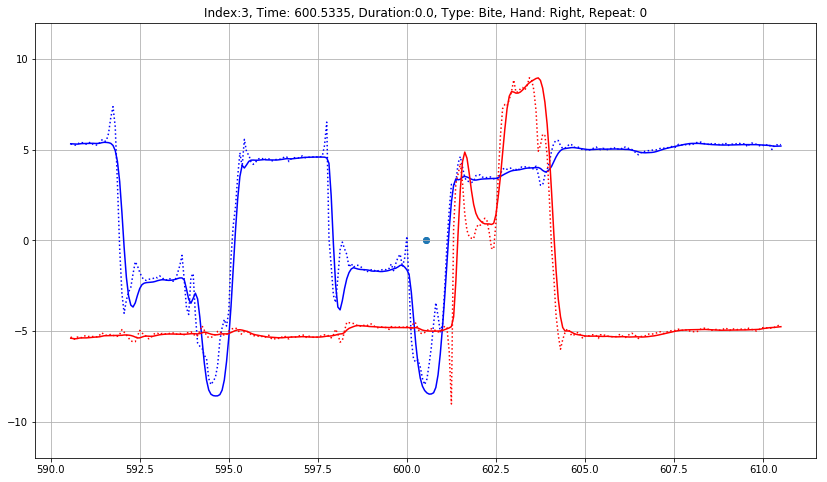

Index:4, Time: 603.5005, Duration:0.0, Type: Bite, Hand: Left, Repeat: 0
603.5005 0.0
320


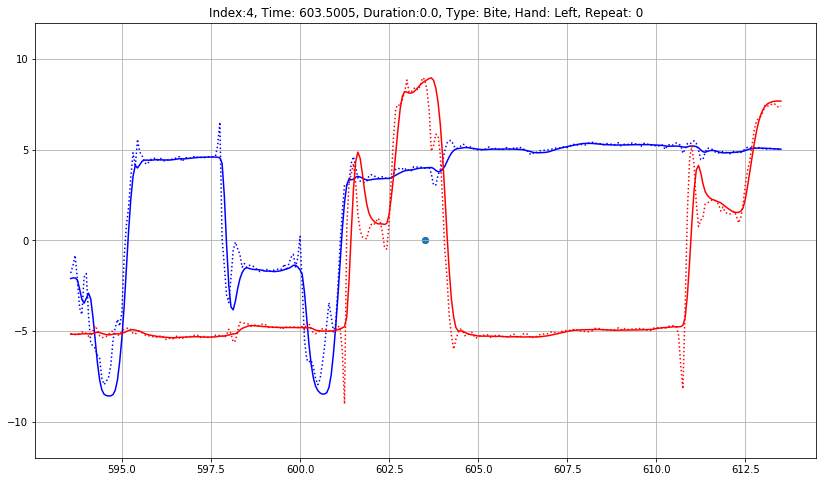

Index:5, Time: 613.2675, Duration:1.5335, Type: Sip, Hand: Left, Repeat: 0
613.2675 1.5335
344


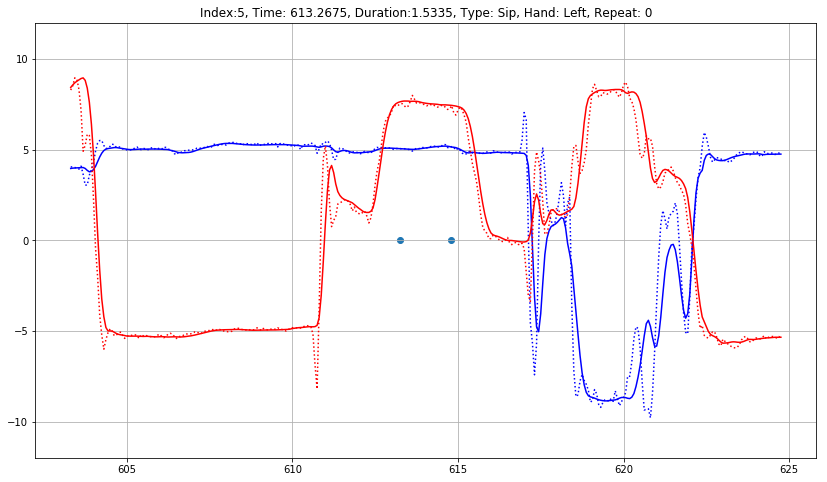

Index:6, Time: 618.967, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
618.967 0.0
320


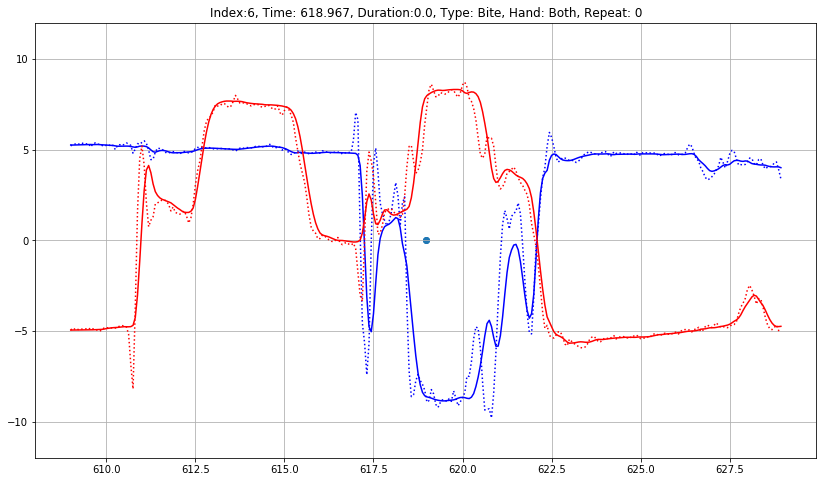

Index:7, Time: 637.301, Duration:1.199, Type: Sip, Hand: Left, Repeat: 0
637.301 1.199
339


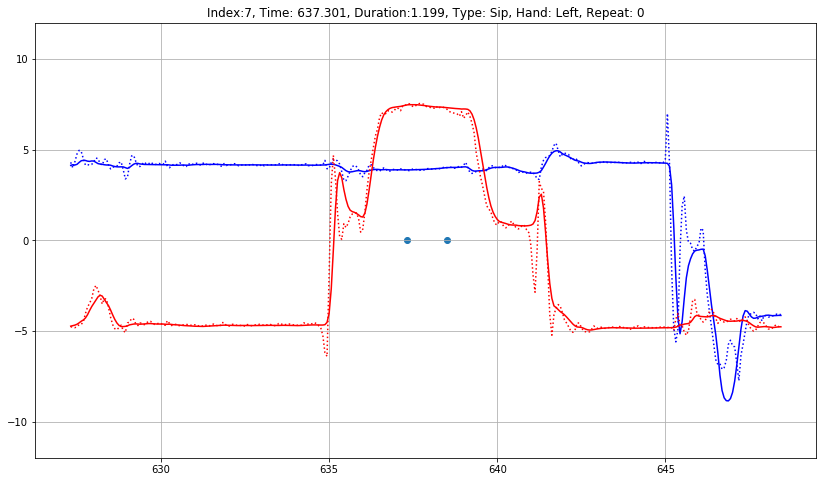

Index:8, Time: 646.8005, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
646.8005 0.0
320


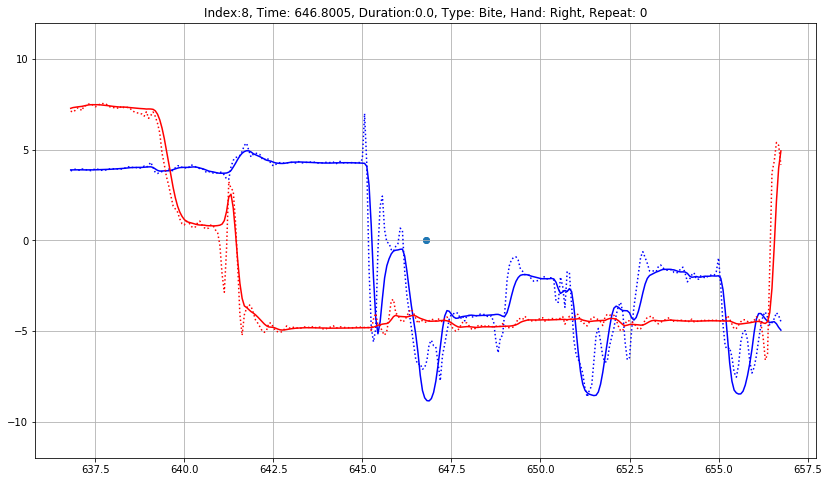

Index:9, Time: 651.4005, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
651.4005 0.0
320


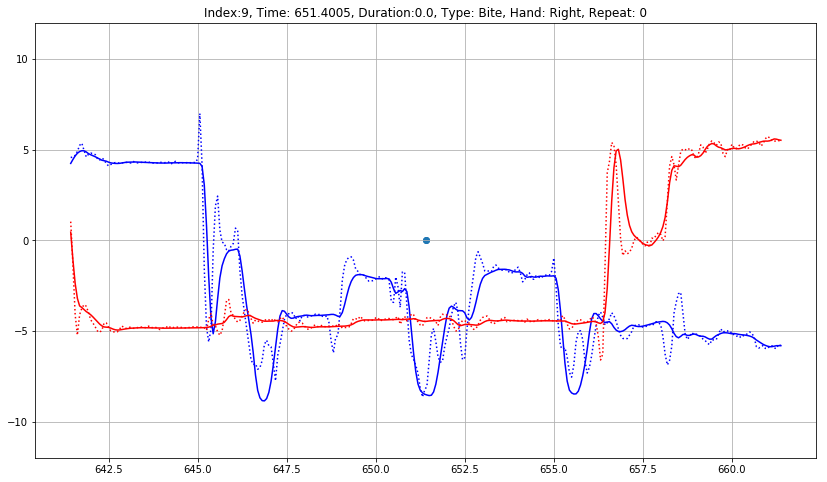

Index:10, Time: 655.5165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
655.5165 0.0
320


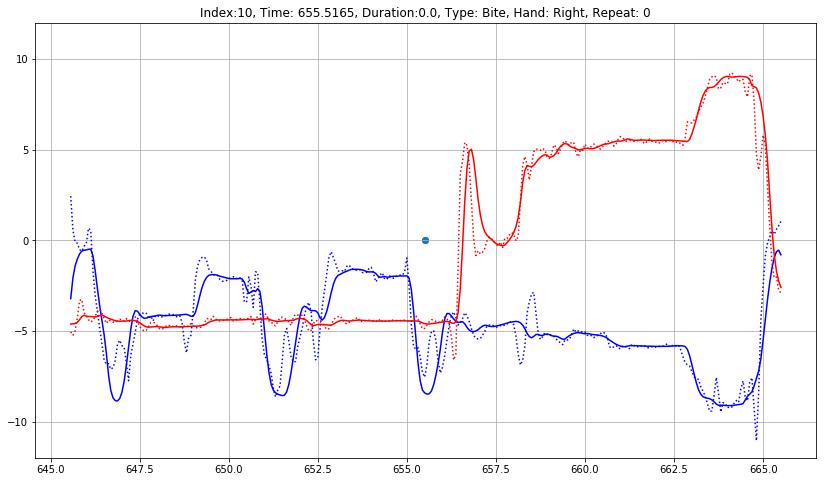

Index:11, Time: 663.6505, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
663.6505 0.0
320


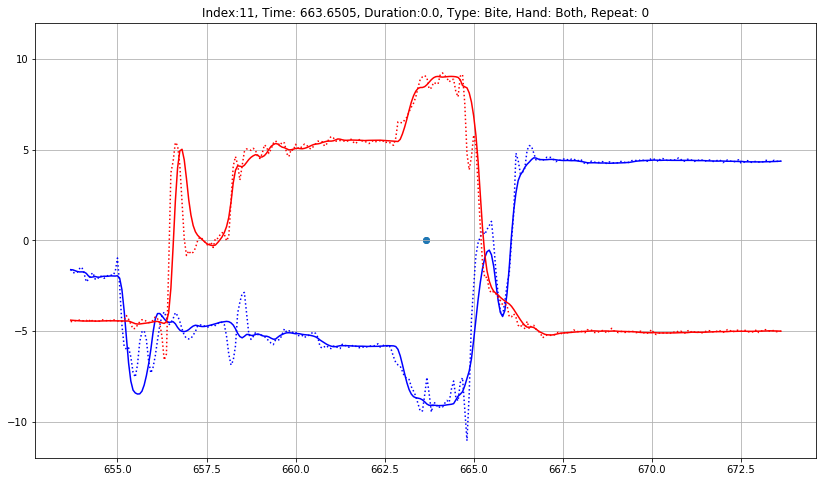

Index:12, Time: 683.4005, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
683.4005 0.0
320


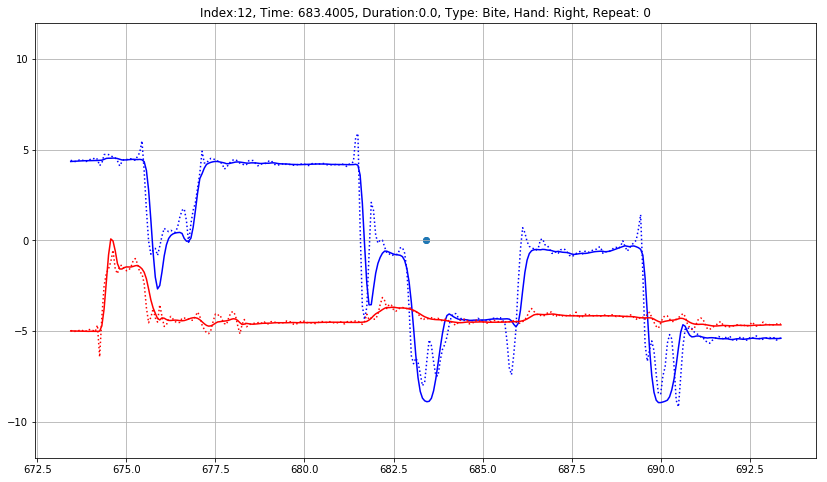

Index:13, Time: 689.951, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
689.951 0.0
320


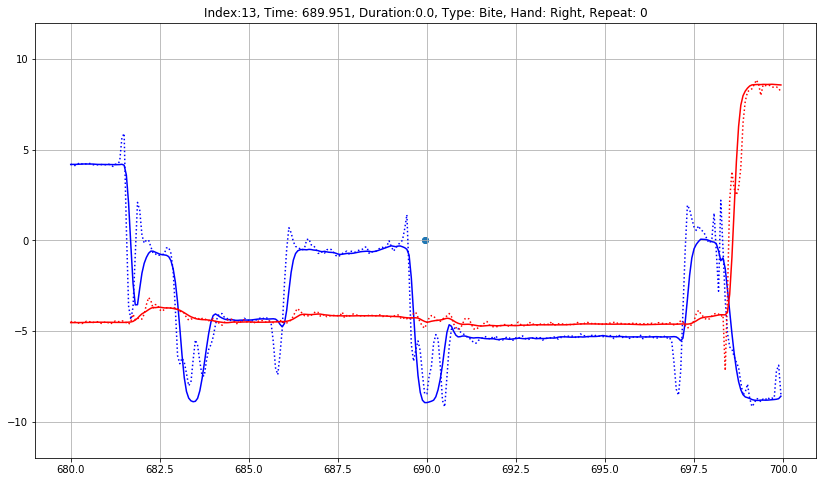

Index:14, Time: 699.033, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
699.033 0.0
320


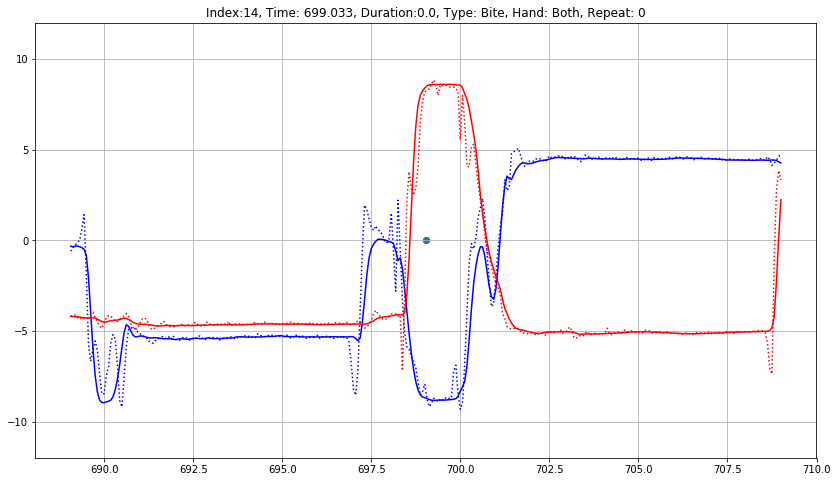

Index:15, Time: 712.0165, Duration:1.634, Type: Sip, Hand: Left, Repeat: 0
712.0165 1.634
346


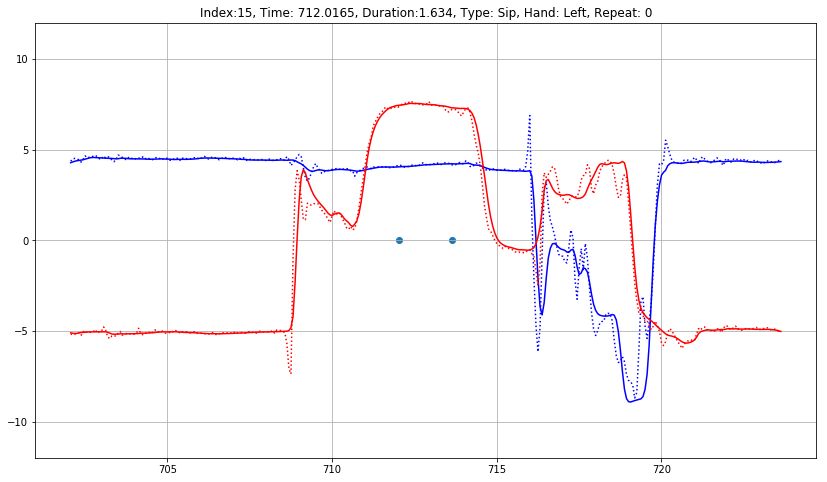

Index:16, Time: 719.1005, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
719.1005 0.0
320


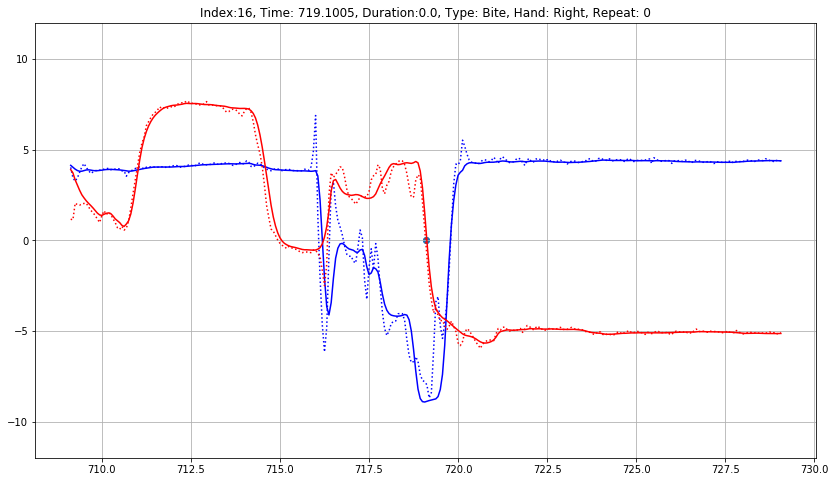

Index:17, Time: 733.884, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
733.884 0.0
320


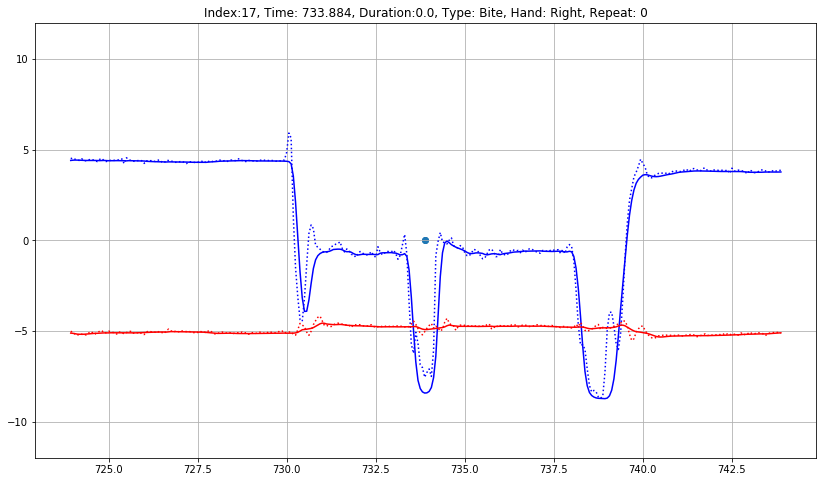

Index:18, Time: 738.668, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
738.668 0.0
320


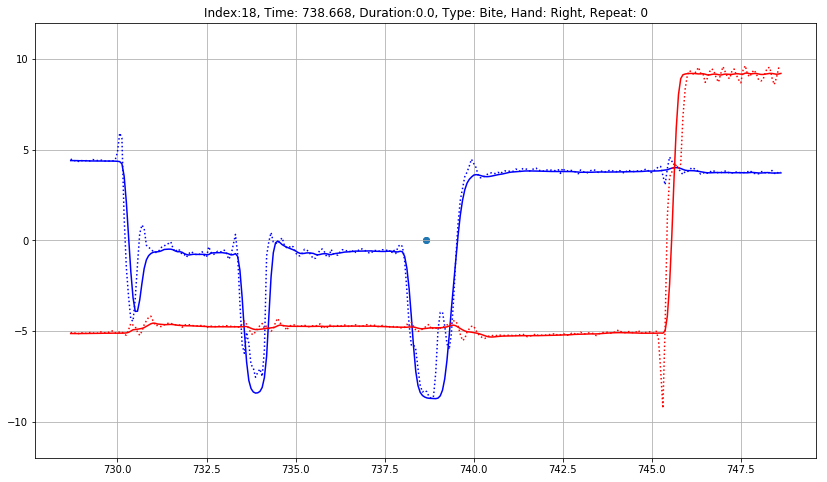

Index:19, Time: 758.7845, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
758.7845 0.0
320


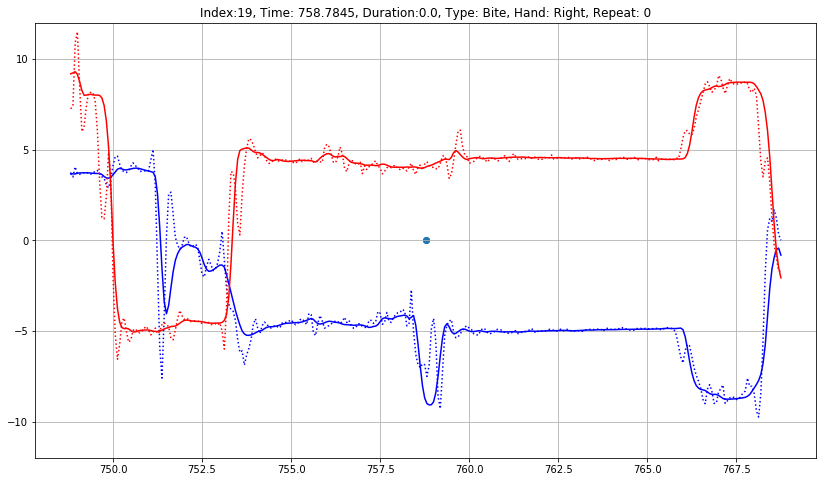

Index:20, Time: 767.084, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
767.084 0.0
320


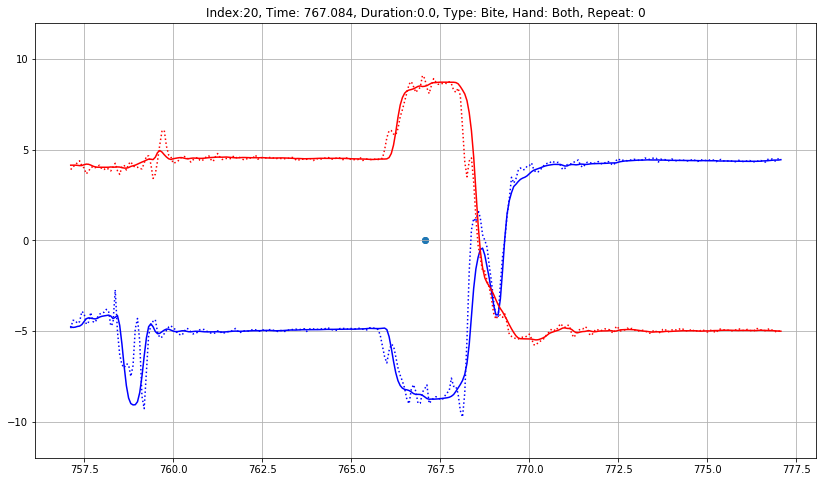

Index:21, Time: 785.8005, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
785.8005 0.0
320


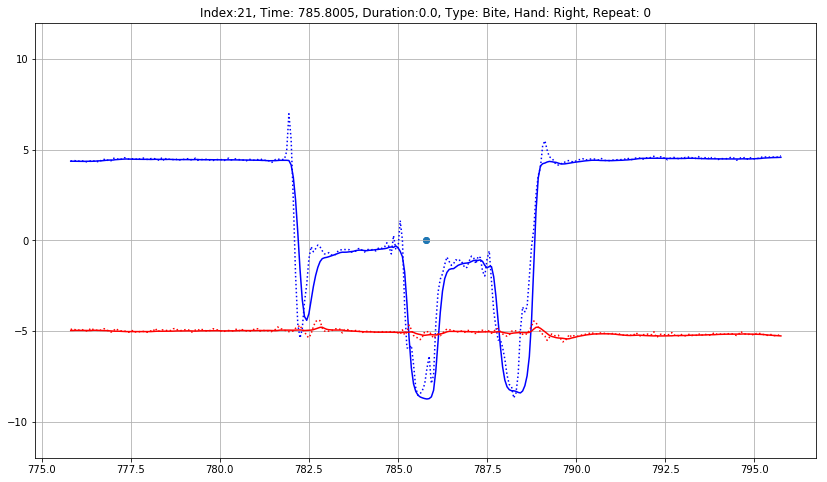

Index:22, Time: 788.1505, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
788.1505 0.0
320


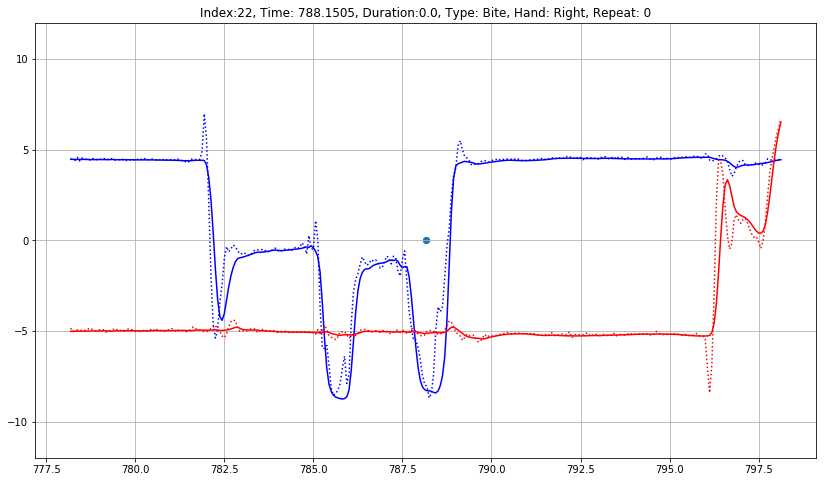

Index:23, Time: 798.6505, Duration:1.8005, Type: Sip, Hand: Left, Repeat: 0
798.6505 1.8005
349


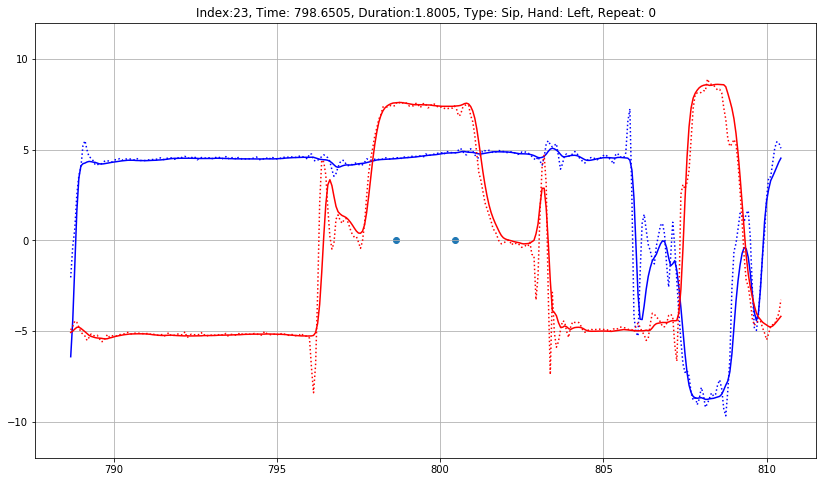

Index:24, Time: 807.834, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
807.834 0.0
320


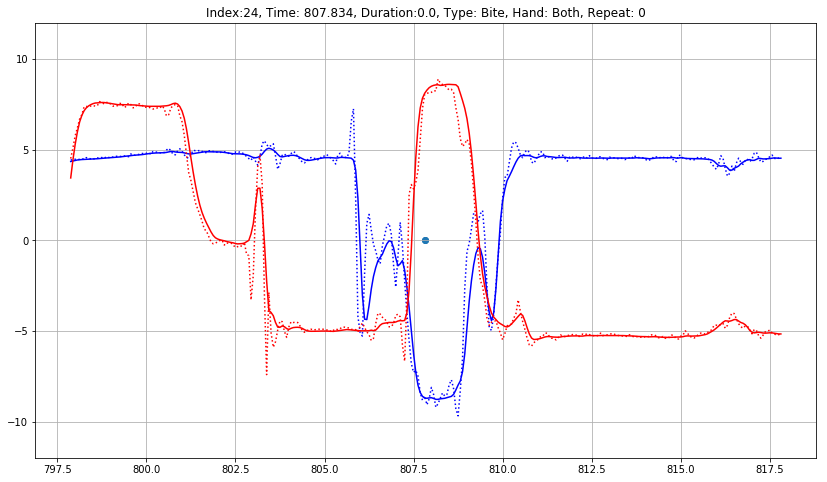

Index:25, Time: 826.6665, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
826.6665 0.0
320


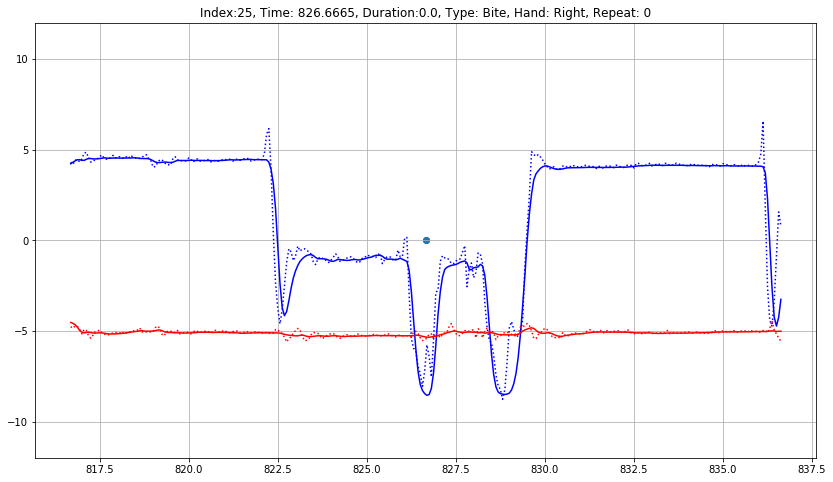

Index:26, Time: 828.734, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
828.734 0.0
320


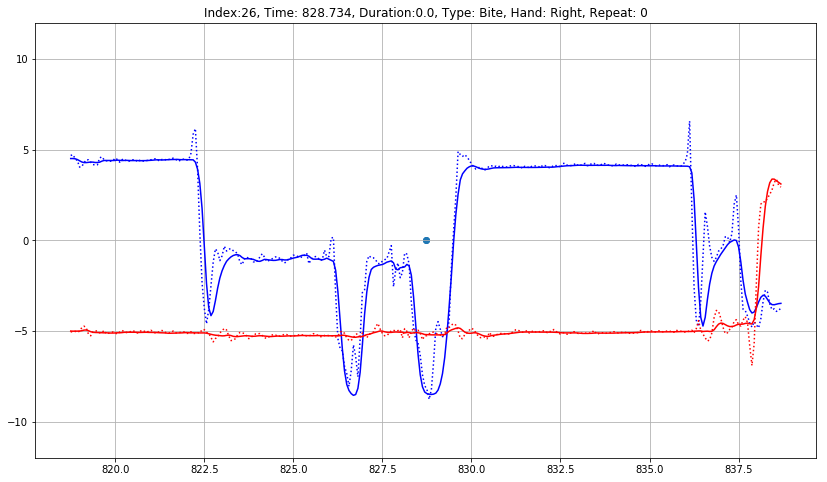

Index:27, Time: 844.484, Duration:0.0, Type: Bite, Hand: Both, Repeat: 0
844.484 0.0
320


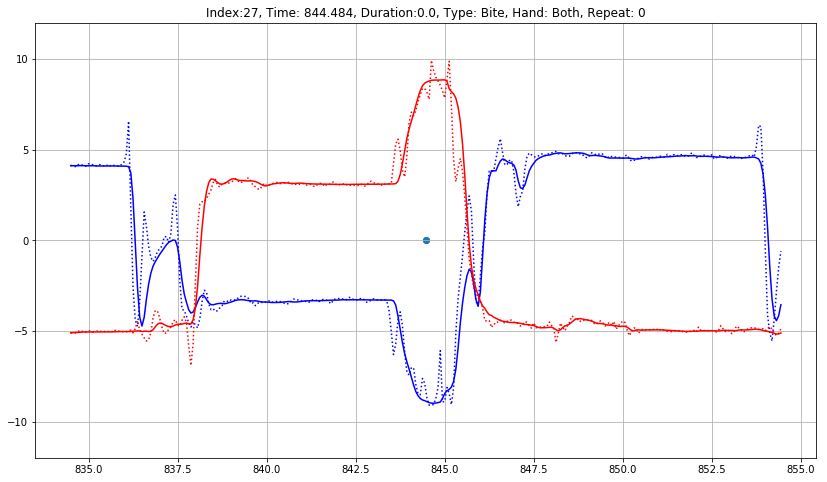

Index:28, Time: 857.0505, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
857.0505 0.0
320


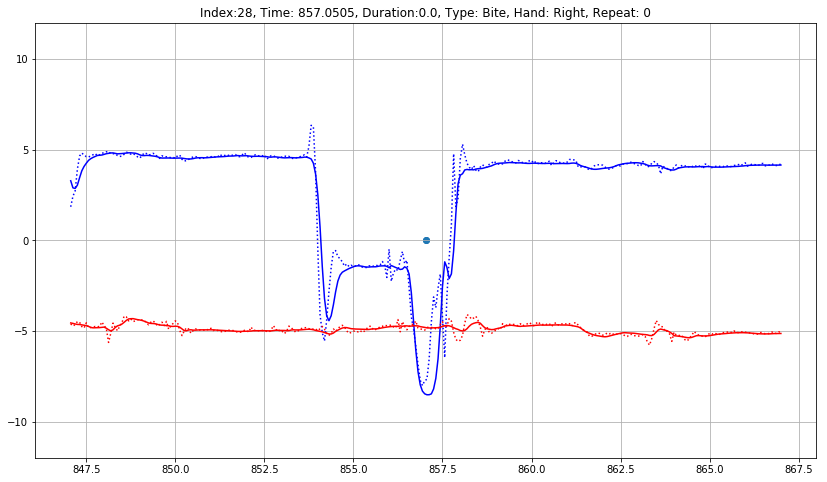

Index:29, Time: 872.2505, Duration:1.767, Type: Sip, Hand: Left, Repeat: 0
872.2505 1.767
348


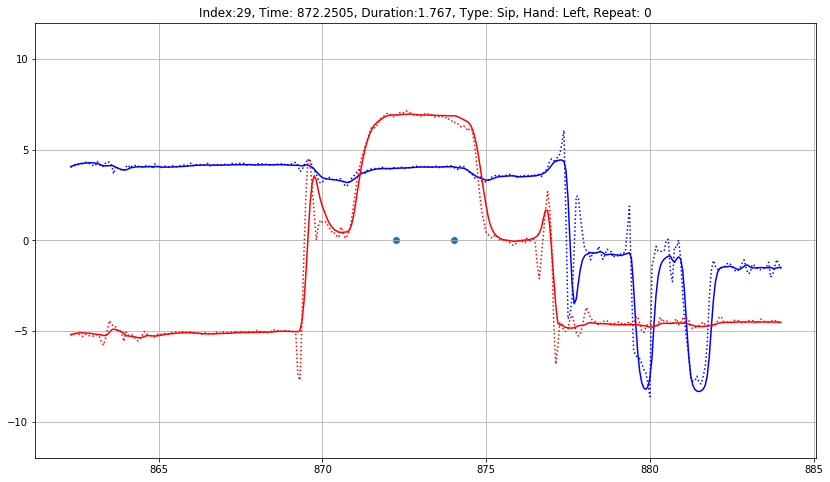

Index:30, Time: 879.801, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
879.801 0.0
320


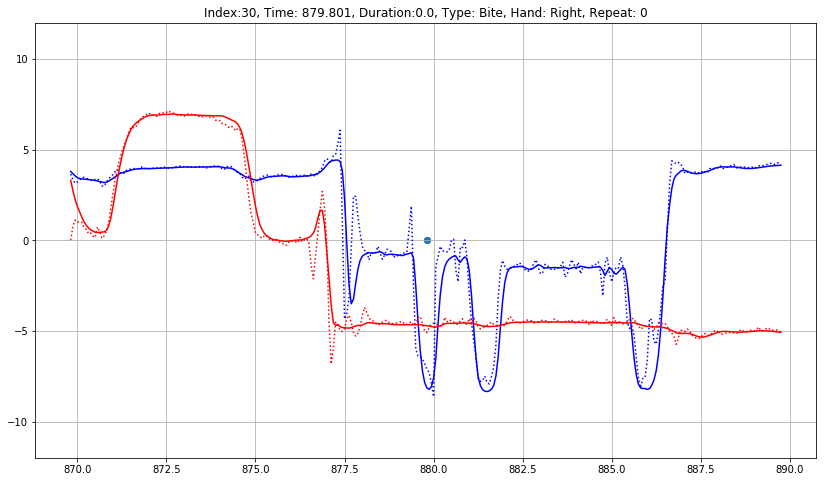

Index:31, Time: 881.4175, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
881.4175 0.0
320


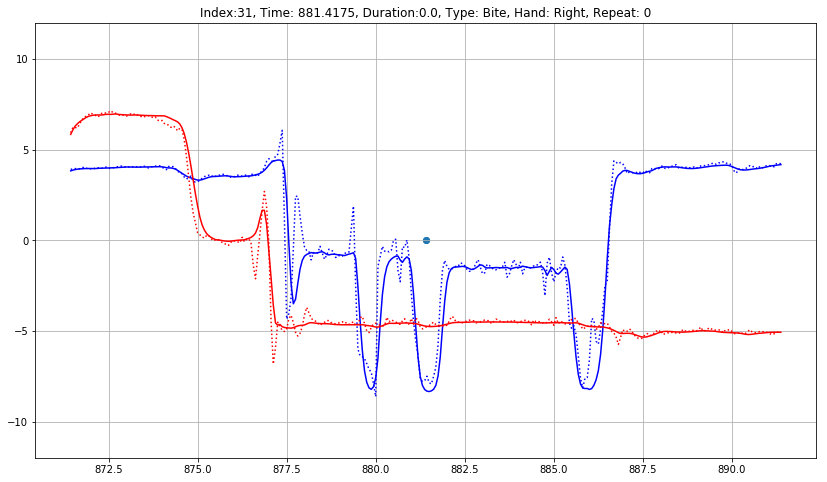

Index:32, Time: 885.8005, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
885.8005 0.0
320


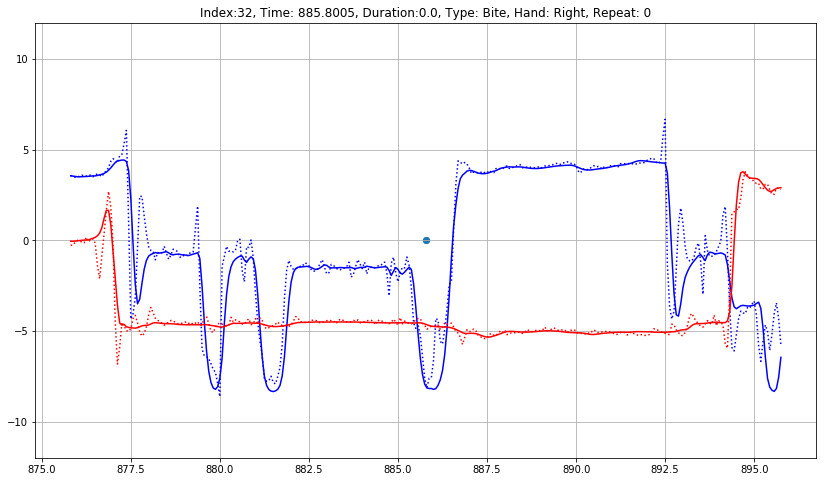

Index:33, Time: 895.484, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
895.484 0.0
320


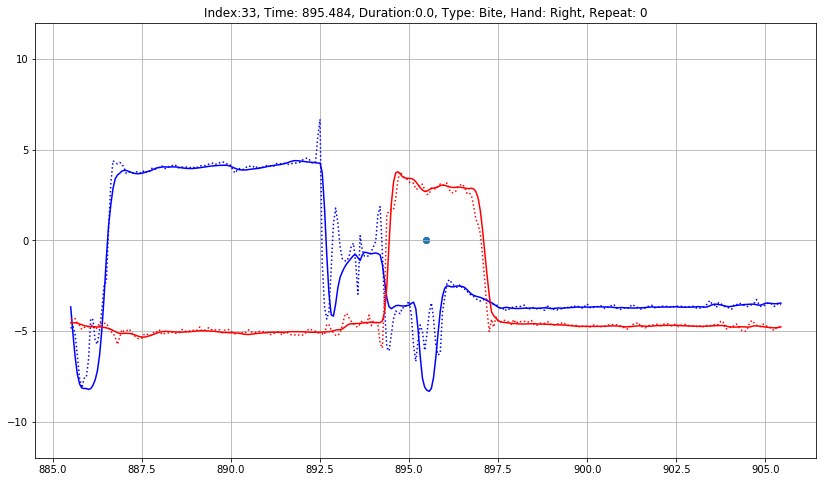

Index:34, Time: 908.1345, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
908.1345 0.0
320


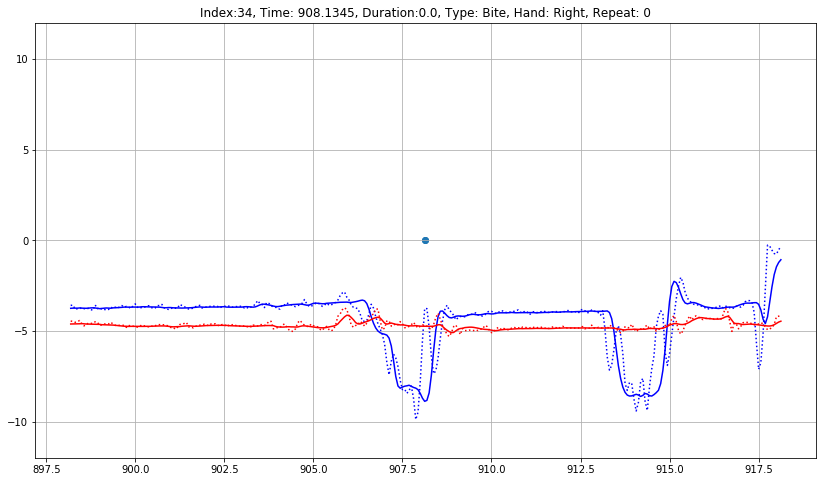

Index:35, Time: 921.6845, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
921.6845 0.0
320


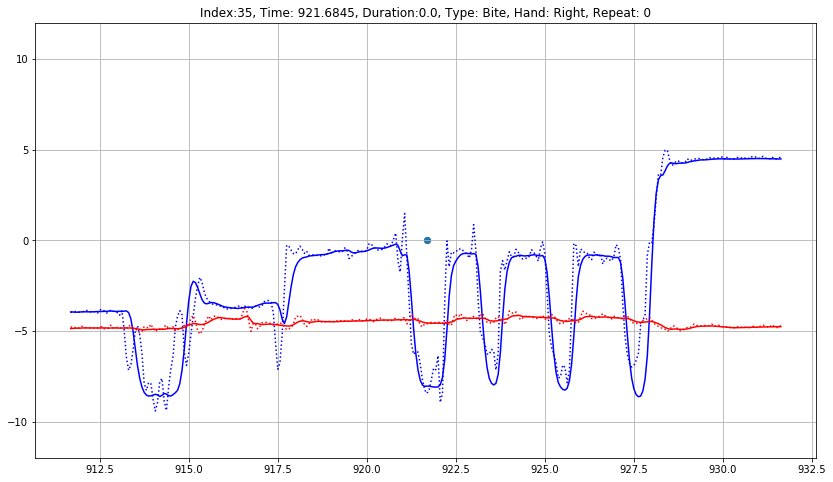

Index:36, Time: 923.567, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
923.567 0.0
320


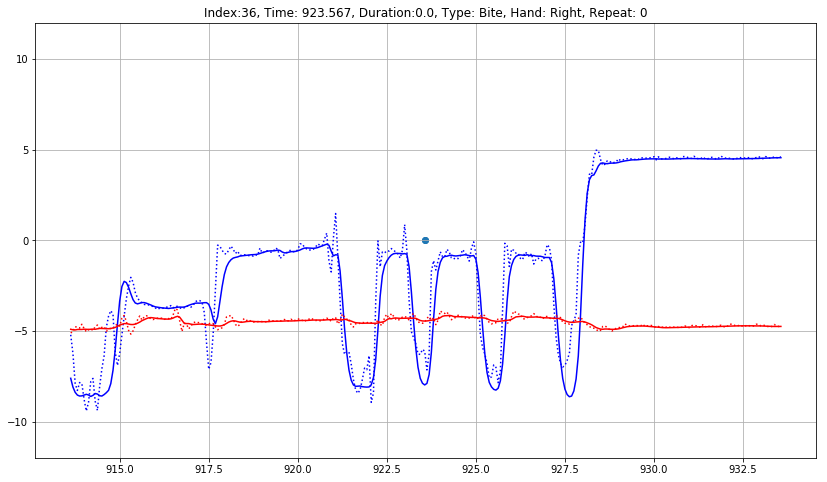

Index:37, Time: 925.5, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
925.5 0.0
319


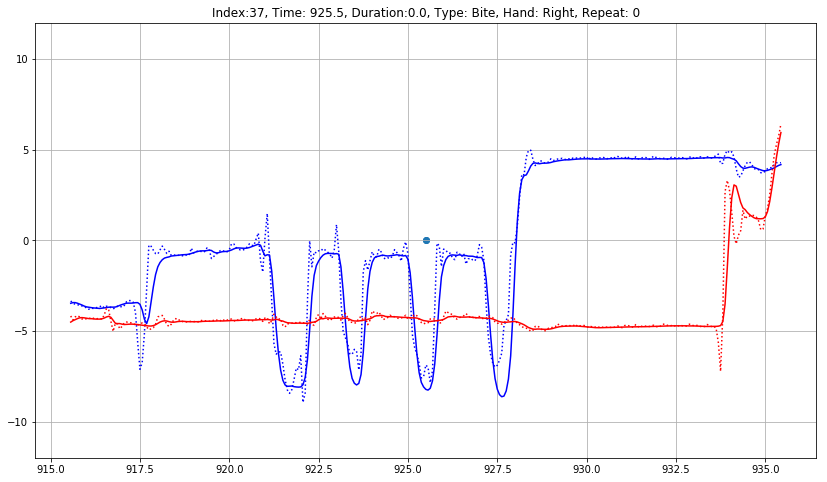

Index:38, Time: 927.617, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
927.617 0.0
320


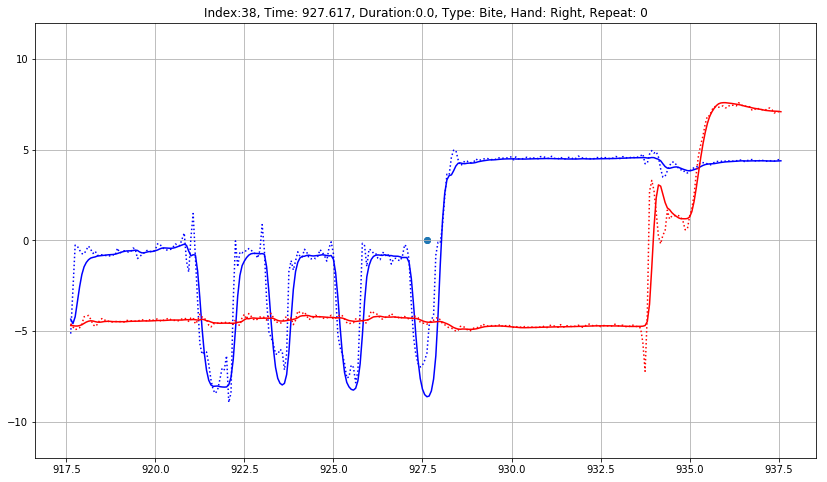

Index:39, Time: 936.1, Duration:3.134, Type: Sip, Hand: Left, Repeat: 0
936.1 3.134
370


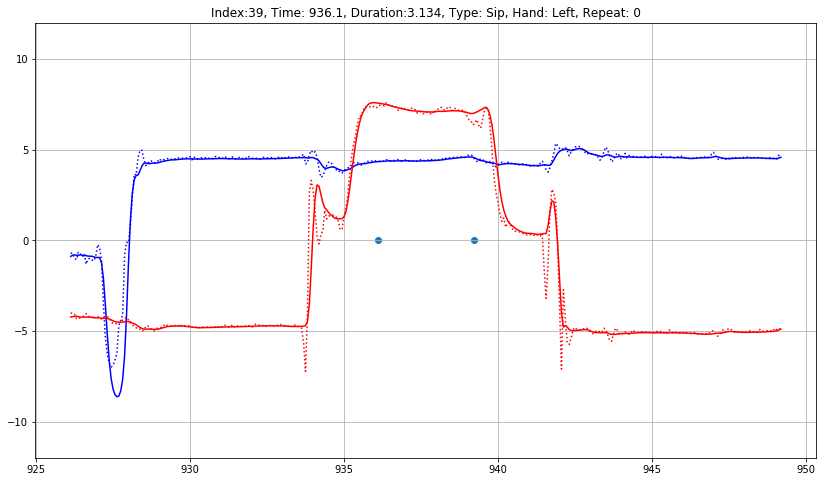

Index:40, Time: 4843.7675, Duration:2.8665, Type: Sip, Hand: Right, Repeat: 0
4843.7675 2.8665
366


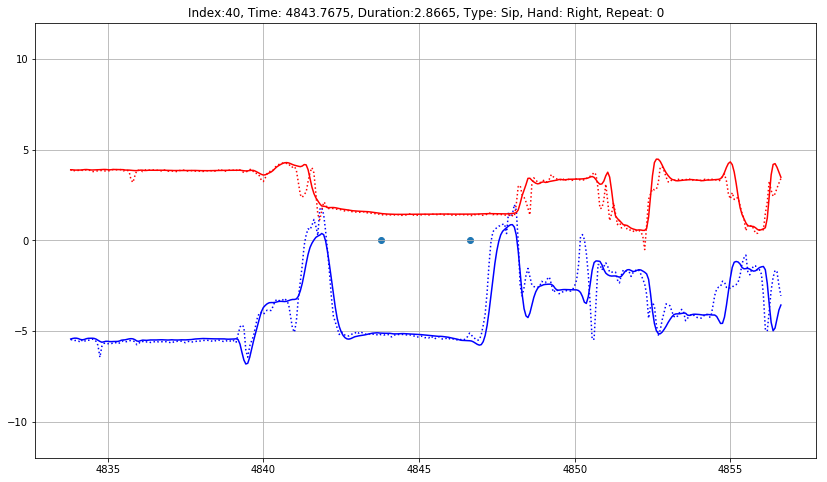

Index:41, Time: 8492.967, Duration:1.967, Type: Sip, Hand: Right, Repeat: 0
8492.967 1.967
351


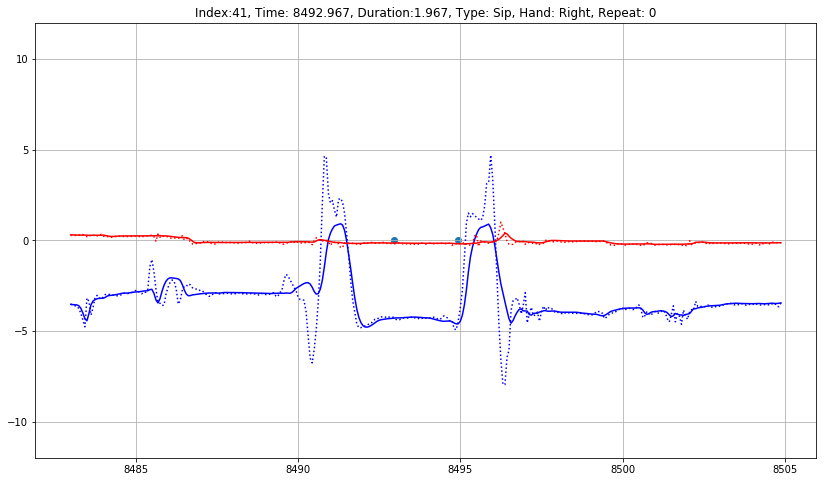

Index:42, Time: 8844.1, Duration:1.601, Type: Sip, Hand: Right, Repeat: 0
8844.1 1.601
346


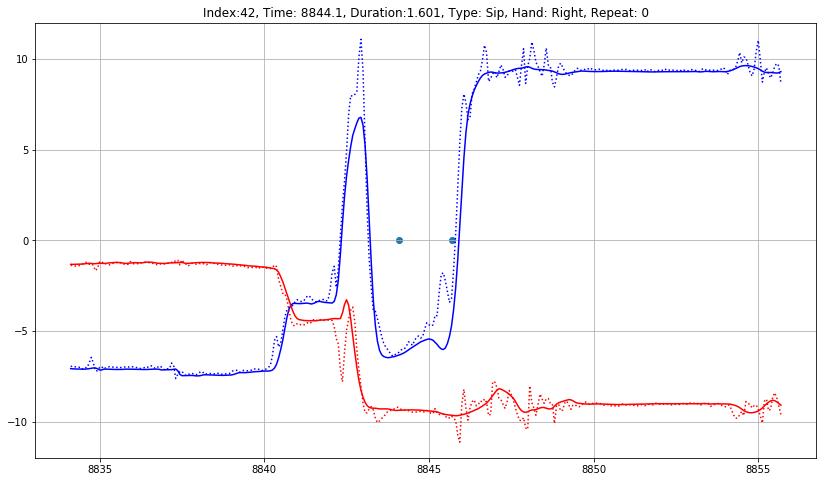

Index:43, Time: 10191.3665, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10191.3665 0.0
320


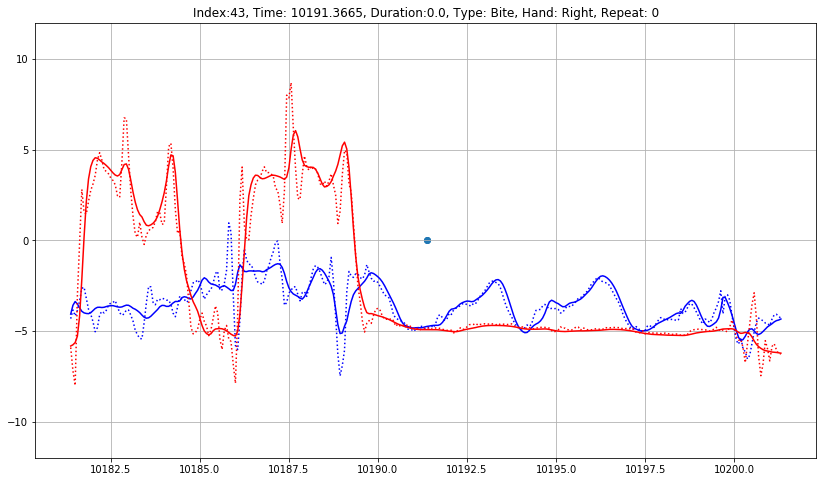

Index:44, Time: 10194.384, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10194.384 0.0
320


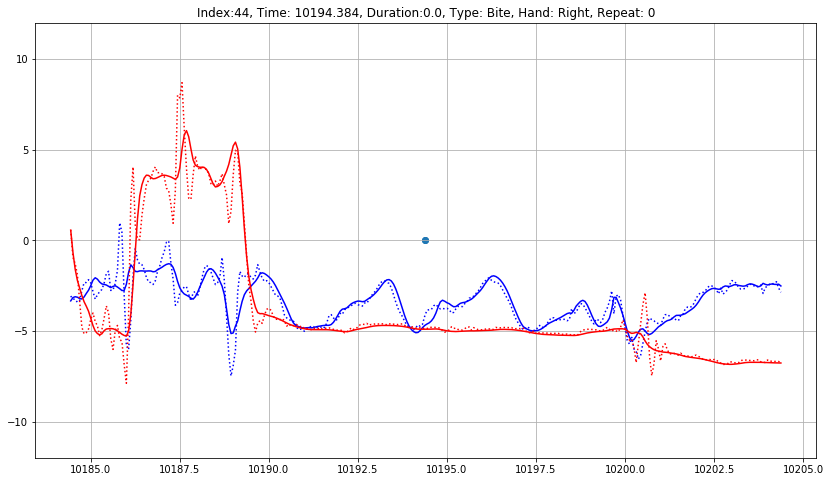

Index:45, Time: 10197.6835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10197.6835 0.0
320


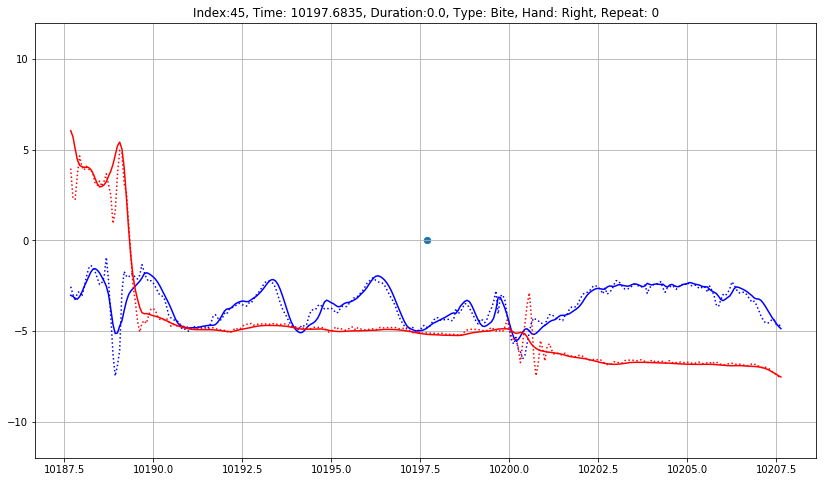

Index:46, Time: 10199.533, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10199.533 0.0
320


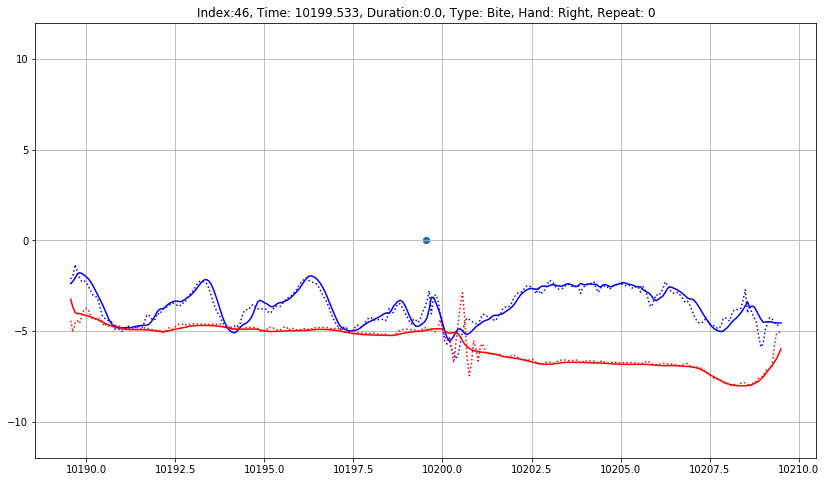

Index:47, Time: 10208.1165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10208.1165 0.0
320


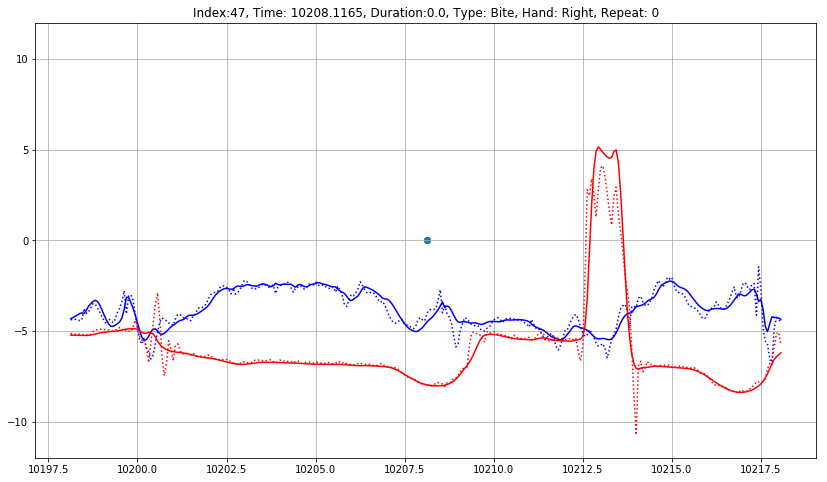

Index:48, Time: 10216.8335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10216.8335 0.0
320


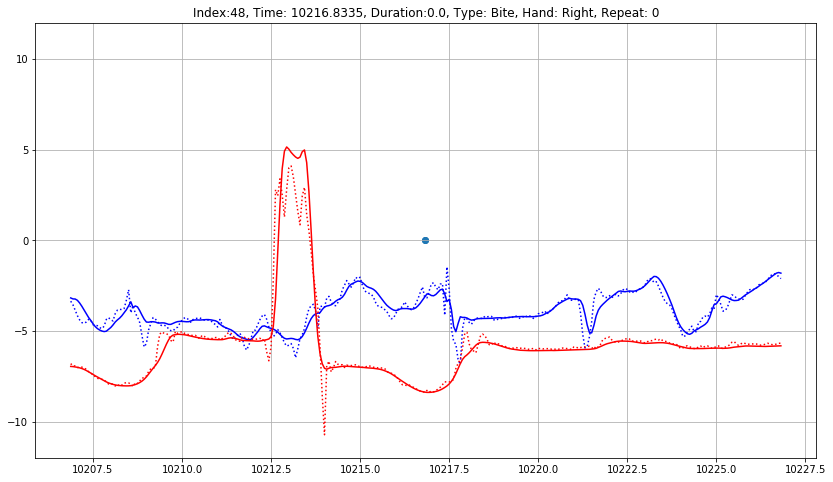

Index:49, Time: 10224.5165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10224.5165 0.0
320


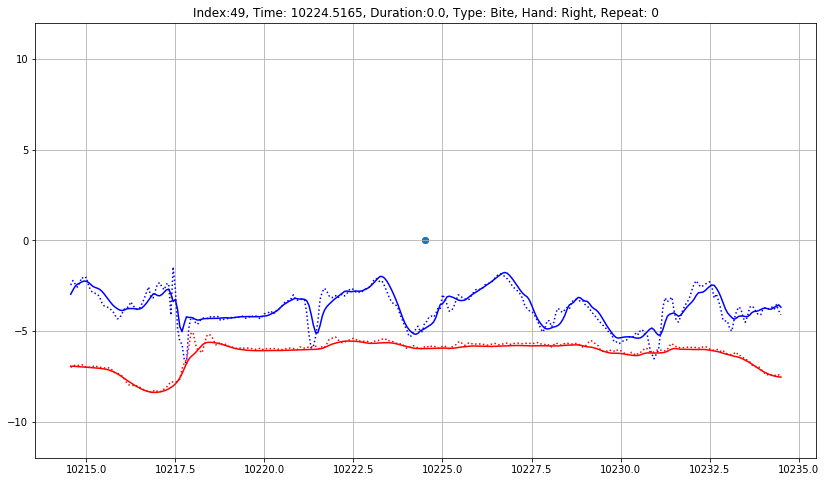

Index:50, Time: 10228.133, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10228.133 0.0
320


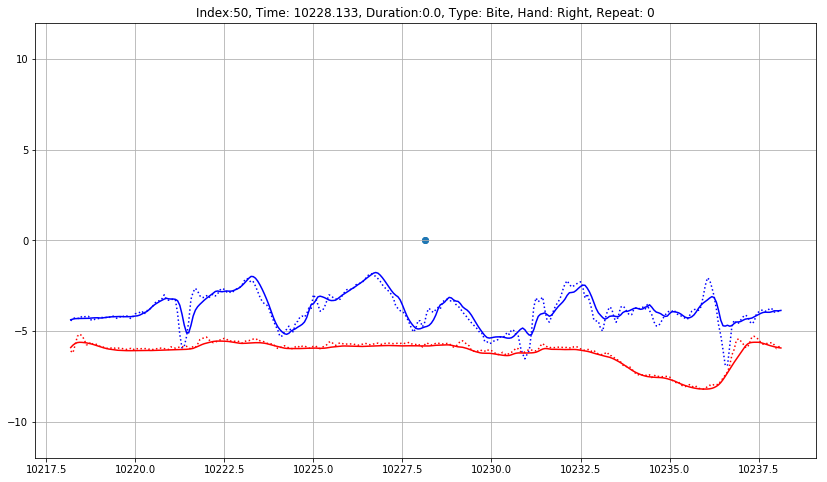

Index:51, Time: 10235.9, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10235.9 0.0
320


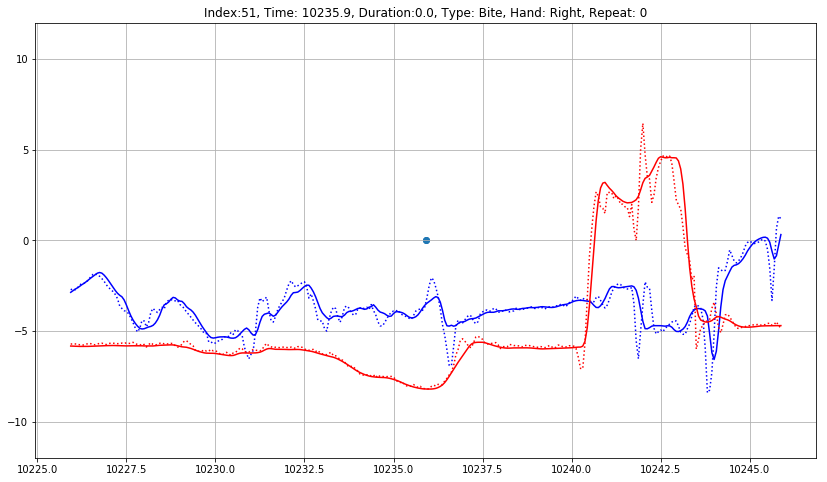

Index:52, Time: 10250.6835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10250.6835 0.0
320


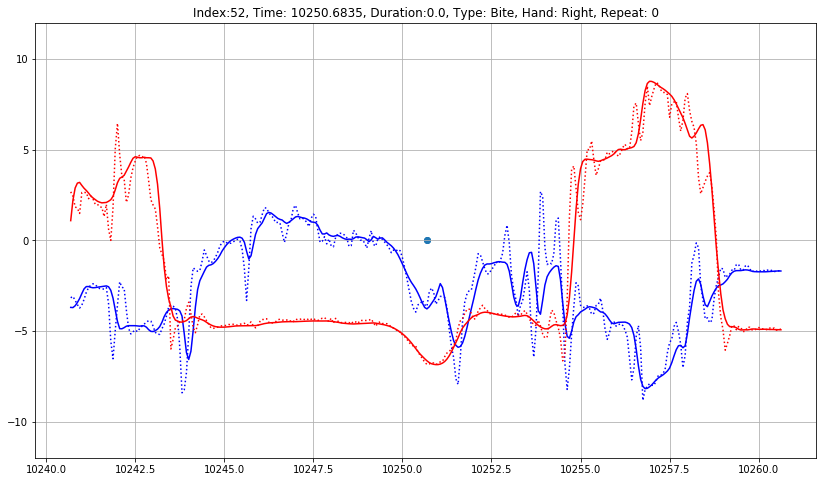

Index:53, Time: 10277.6, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10277.6 0.0
320


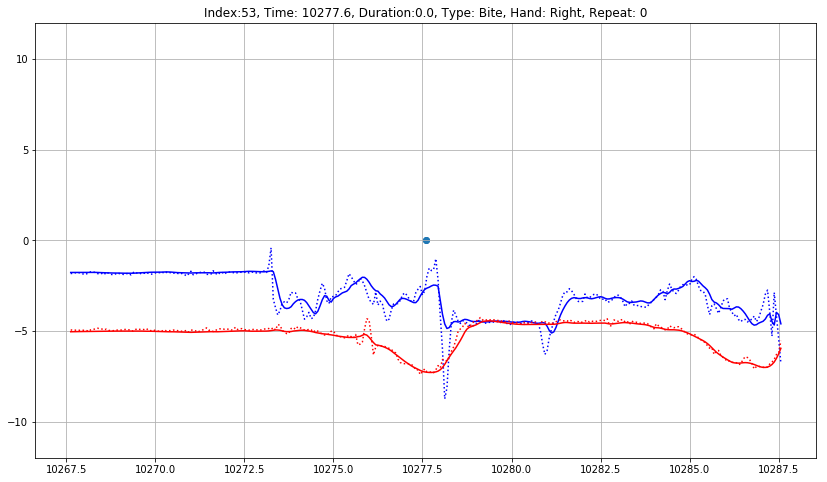

Index:54, Time: 10287.0505, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10287.0505 0.0
320


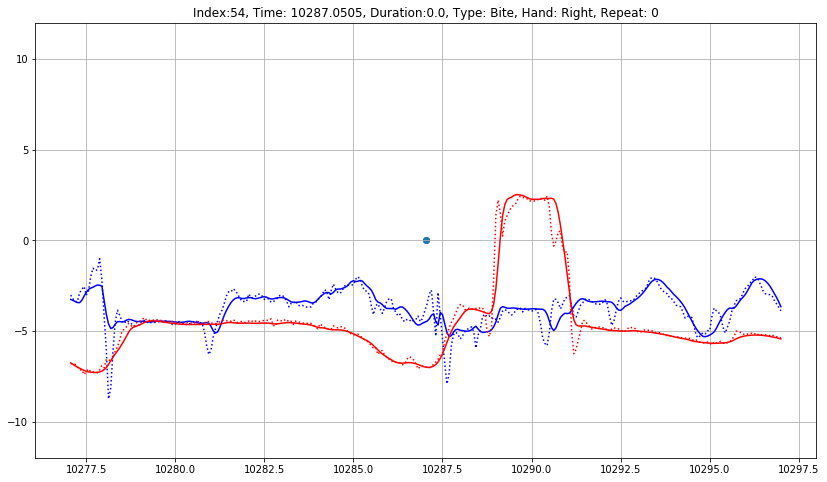

Index:55, Time: 10295.067, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10295.067 0.0
320


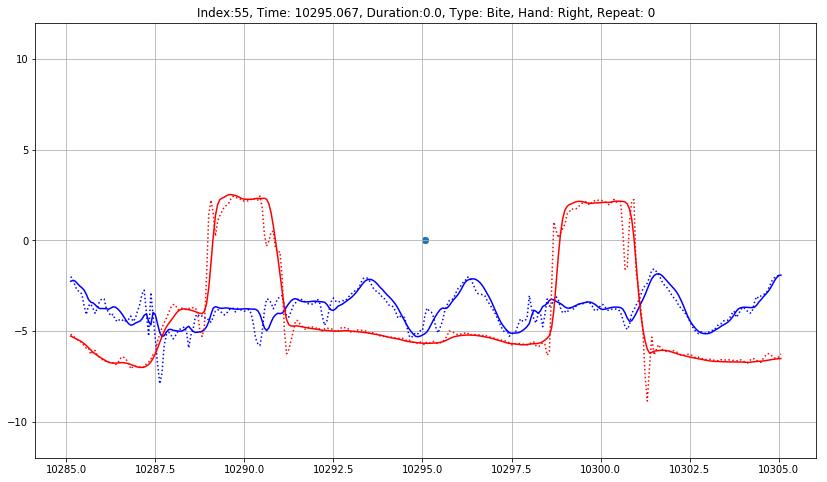

Index:56, Time: 10297.701, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10297.701 0.0
320


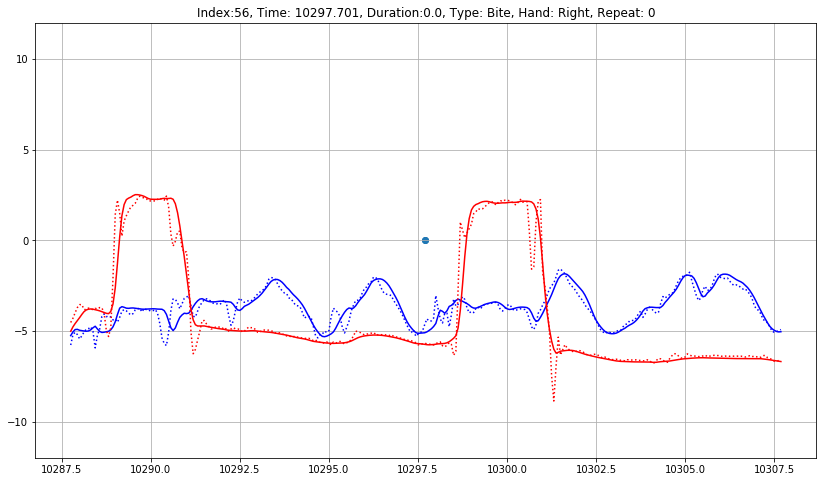

Index:57, Time: 10303.1835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10303.1835 0.0
320


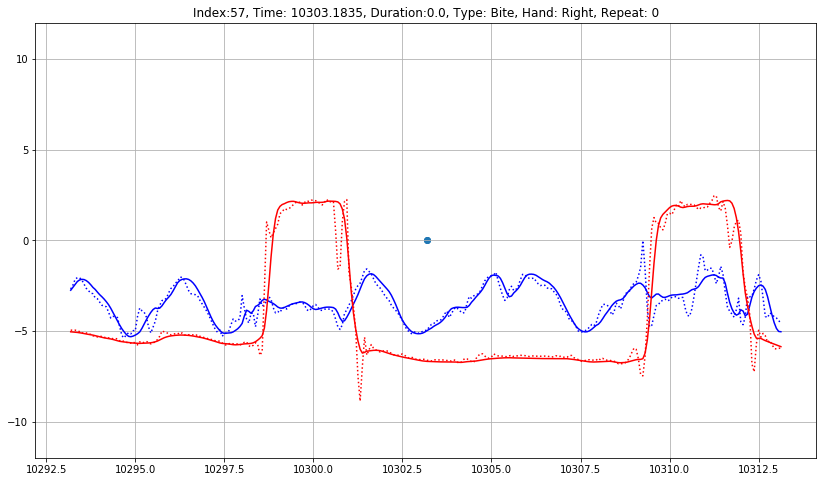

Index:58, Time: 10307.85, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10307.85 0.0
320


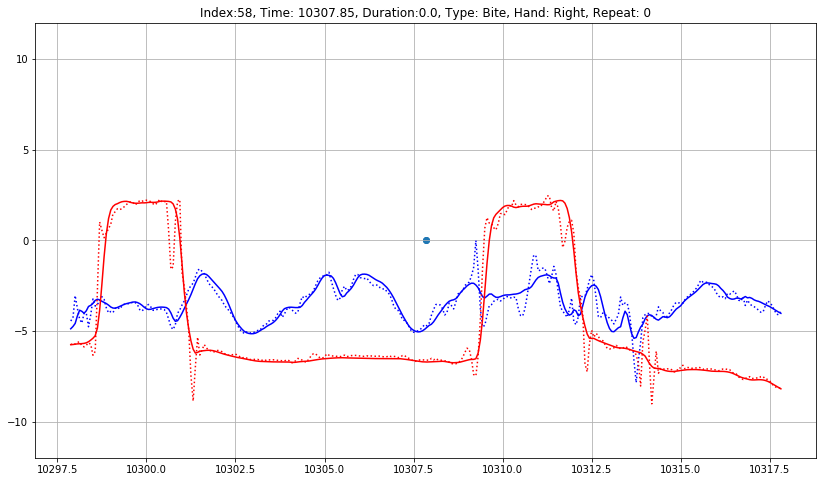

Index:59, Time: 10313.333, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10313.333 0.0
320


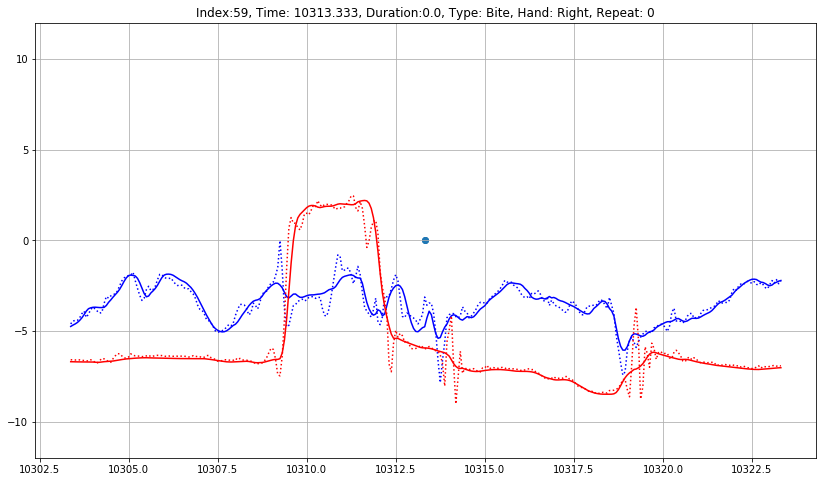

Index:60, Time: 10318.201, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10318.201 0.0
320


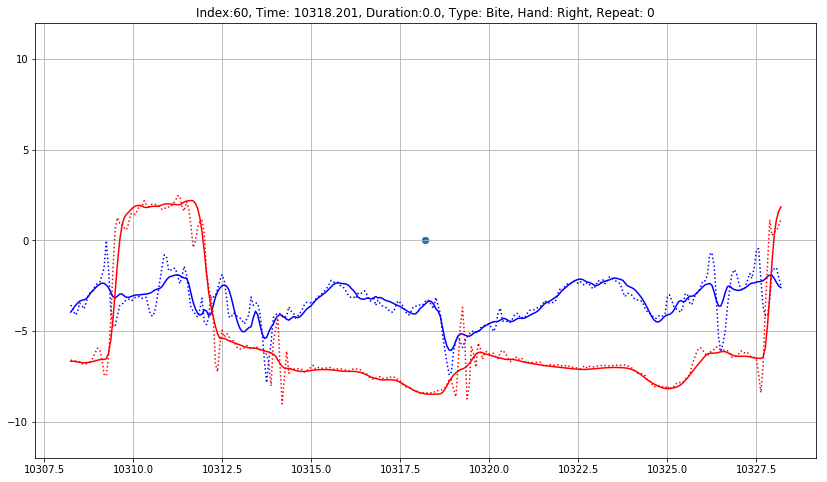

Index:61, Time: 10324.9335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10324.9335 0.0
320


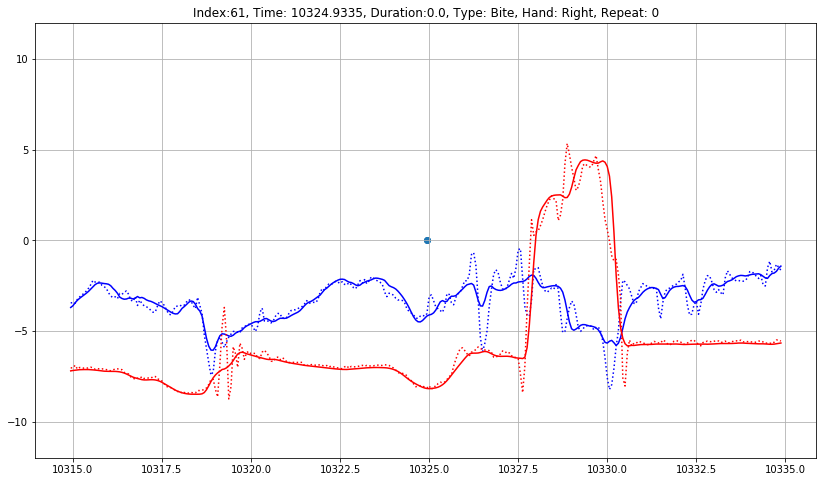

Index:62, Time: 10340.701, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10340.701 0.0
320


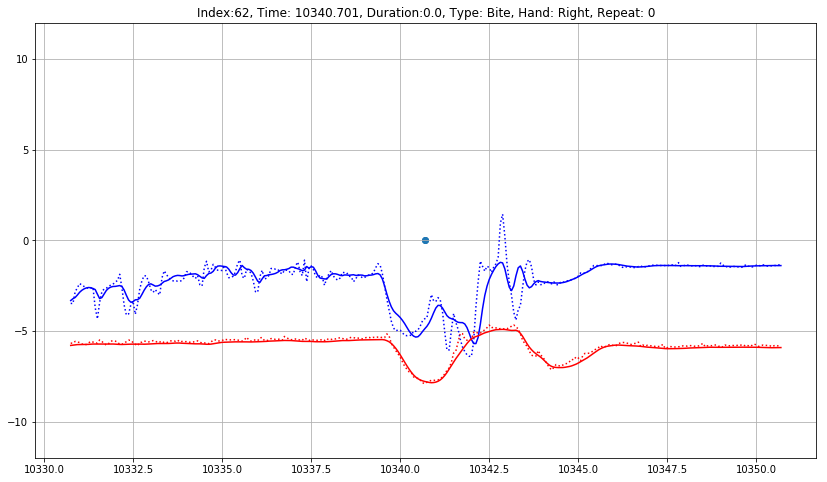

Index:63, Time: 10360.1835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10360.1835 0.0
320


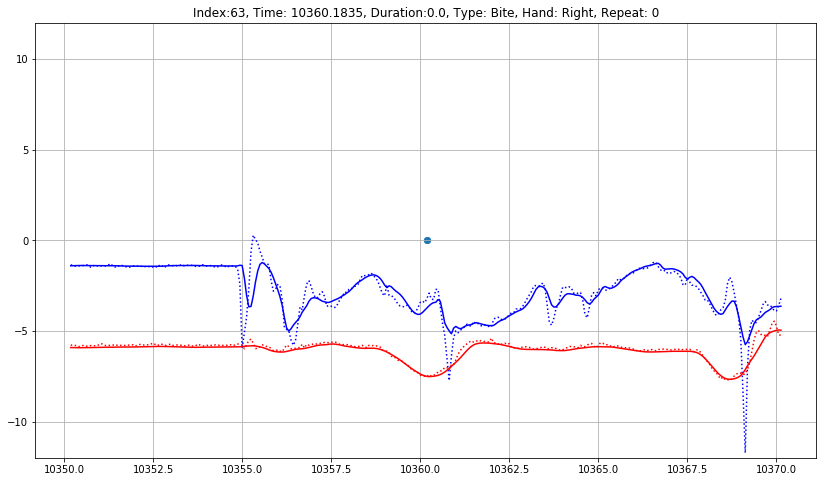

Index:64, Time: 10368.633, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10368.633 0.0
320


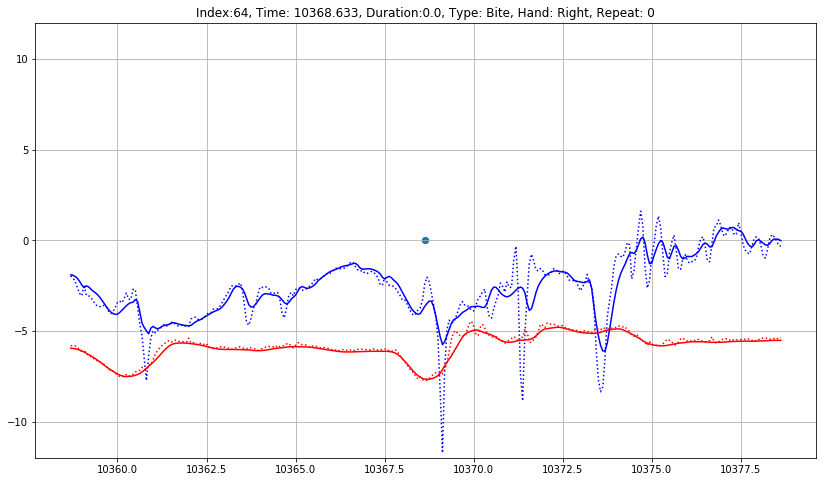

Index:65, Time: 10382.9665, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10382.9665 0.0
320


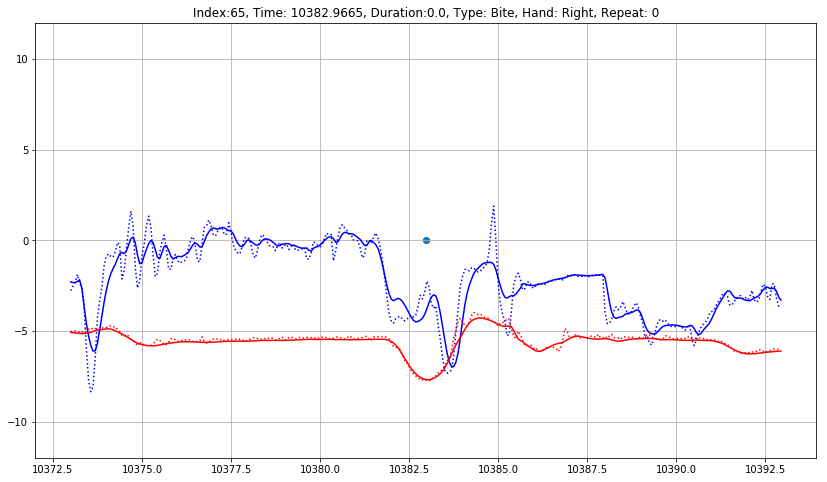

Index:66, Time: 10396.3165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10396.3165 0.0
320


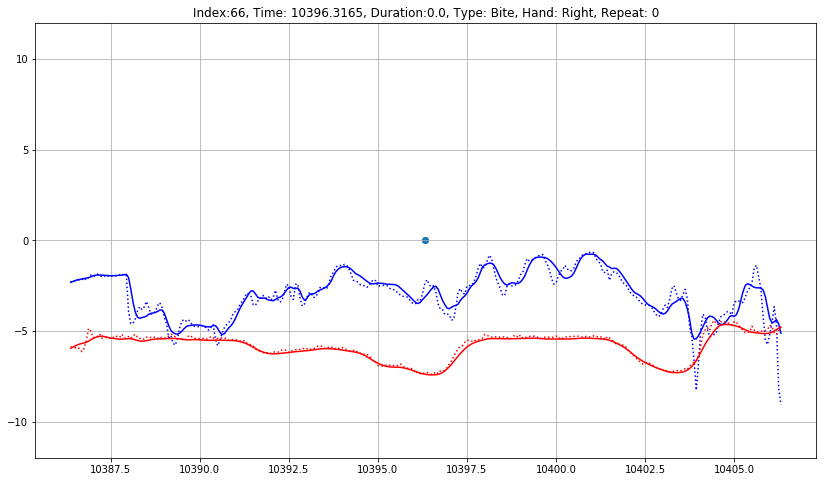

Index:67, Time: 10403.2165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10403.2165 0.0
320


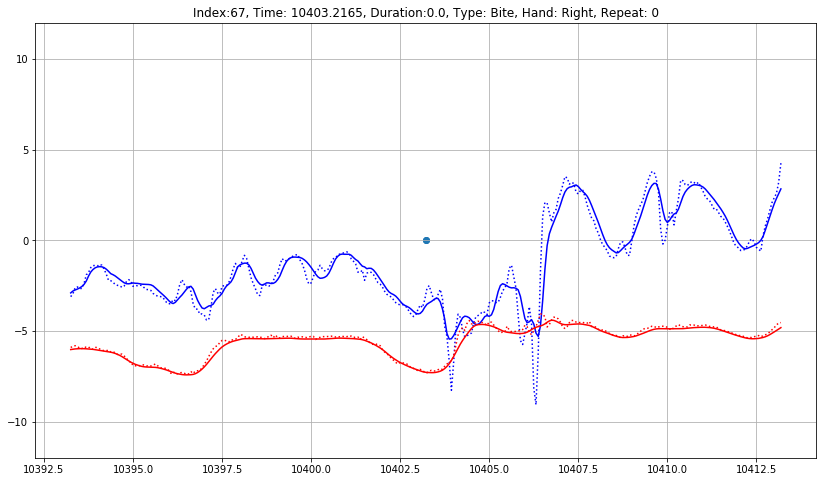

Index:68, Time: 10408.7, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10408.7 0.0
320


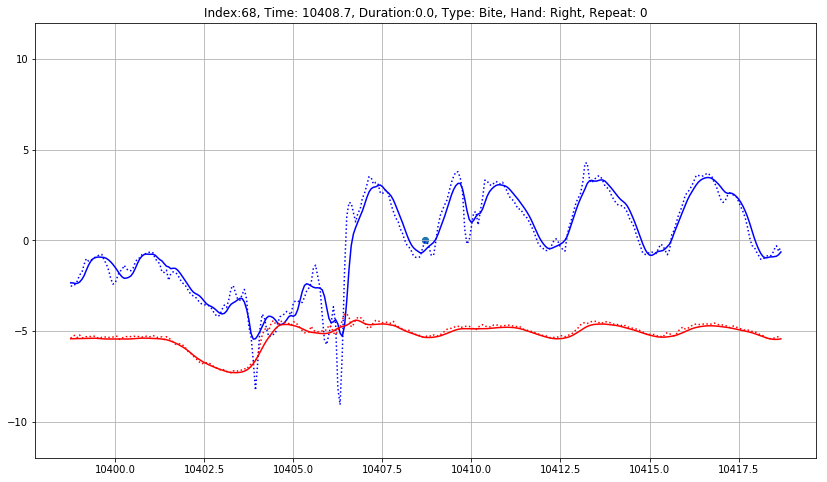

Index:69, Time: 10412.25, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10412.25 0.0
319


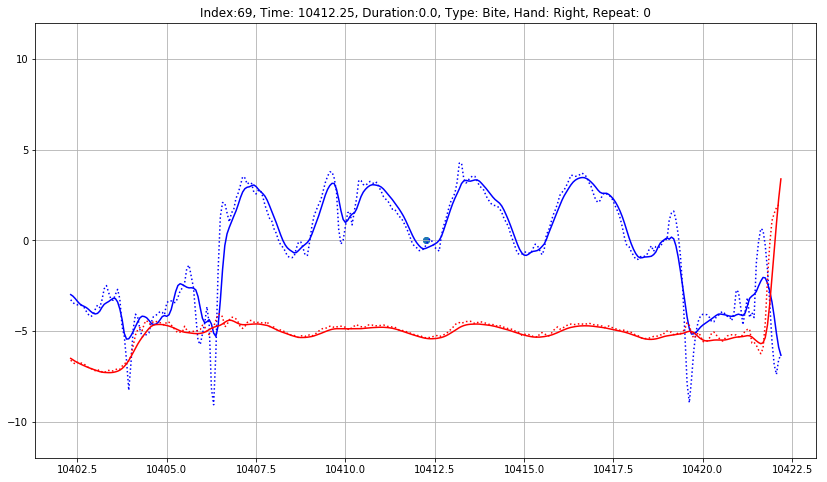

Index:70, Time: 10415.267, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10415.267 0.0
320


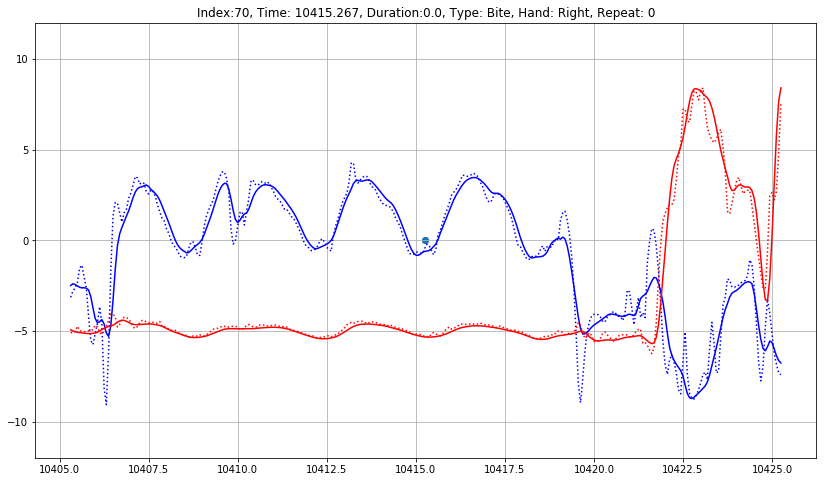

Index:71, Time: 10418.4335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10418.4335 0.0
320


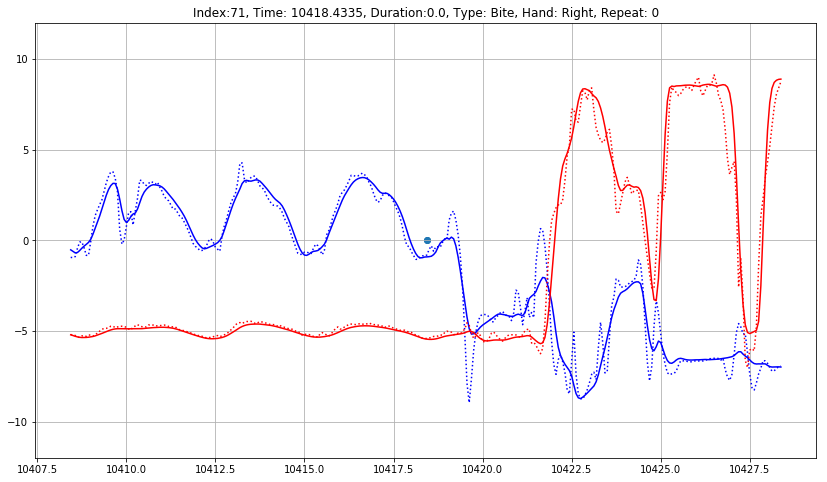

Index:72, Time: 10446.6165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10446.6165 0.0
320


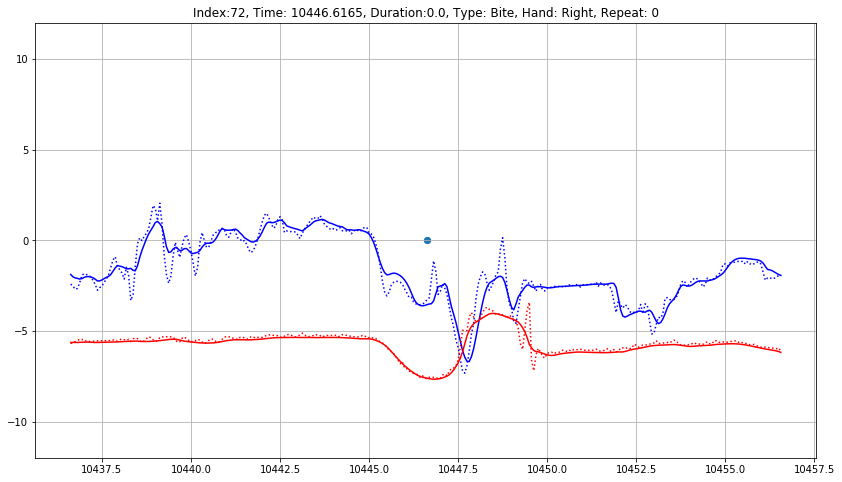

Index:73, Time: 10465.6835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10465.6835 0.0
320


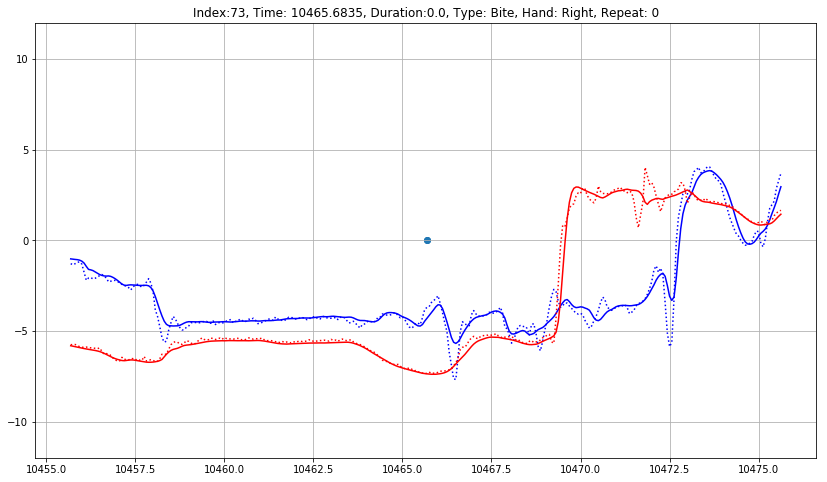

Index:74, Time: 10475.0, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10475.0 0.0
319


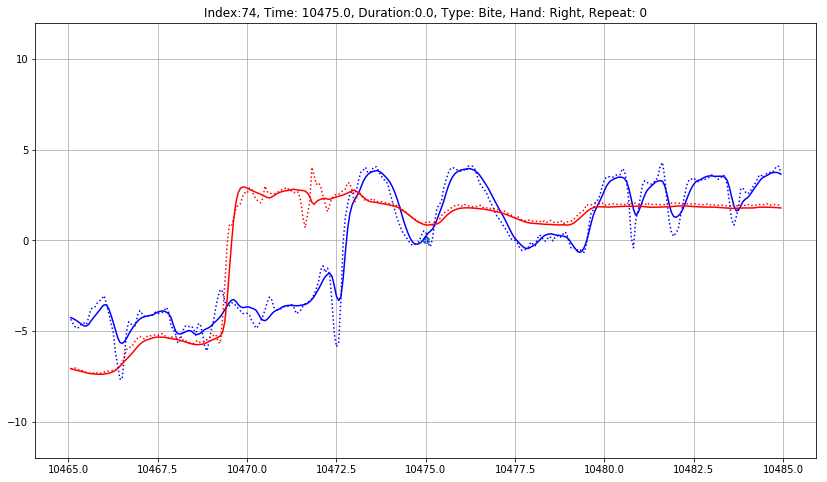

Index:75, Time: 10478.1, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10478.1 0.0
320


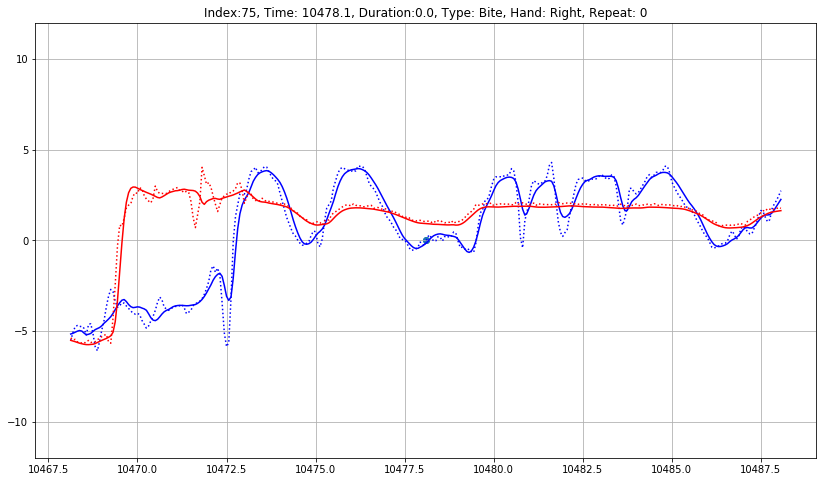

Index:76, Time: 10486.5835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10486.5835 0.0
320


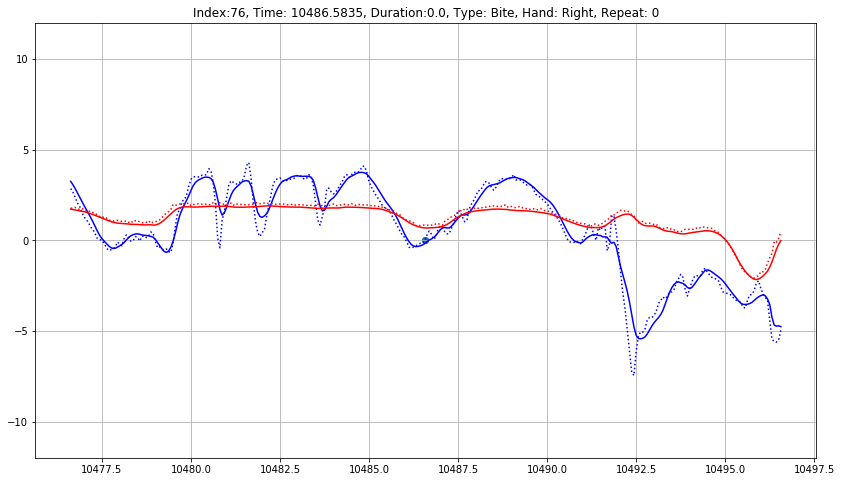

Index:77, Time: 10491.133, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10491.133 0.0
320


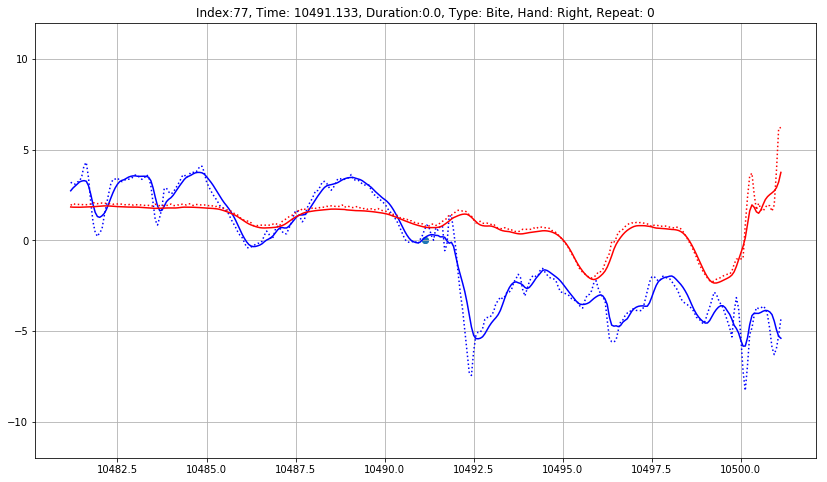

Index:78, Time: 10495.9, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10495.9 0.0
320


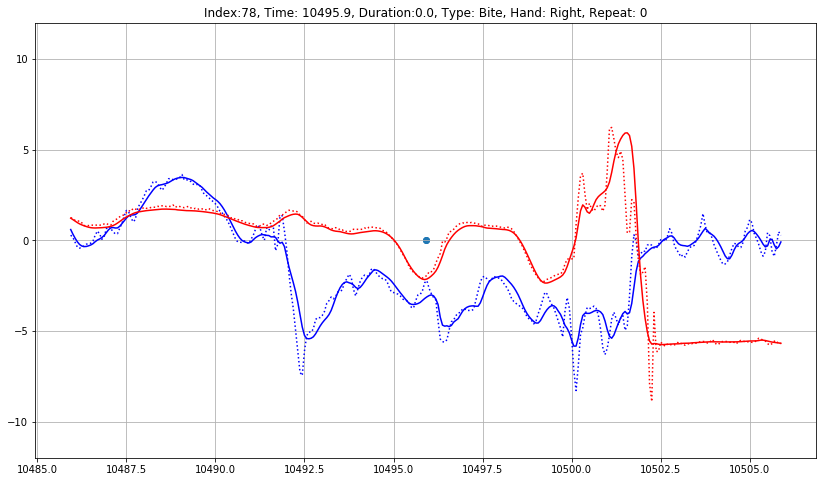

Index:79, Time: 10499.3335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10499.3335 0.0
320


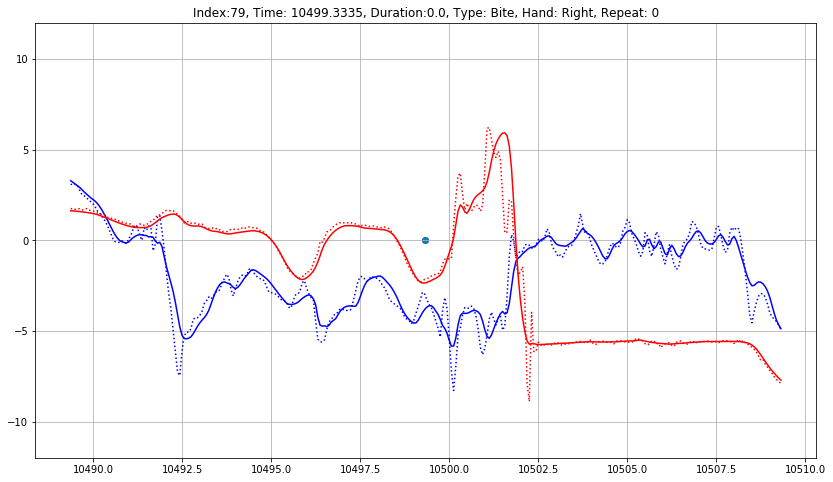

Index:80, Time: 10509.567, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10509.567 0.0
320


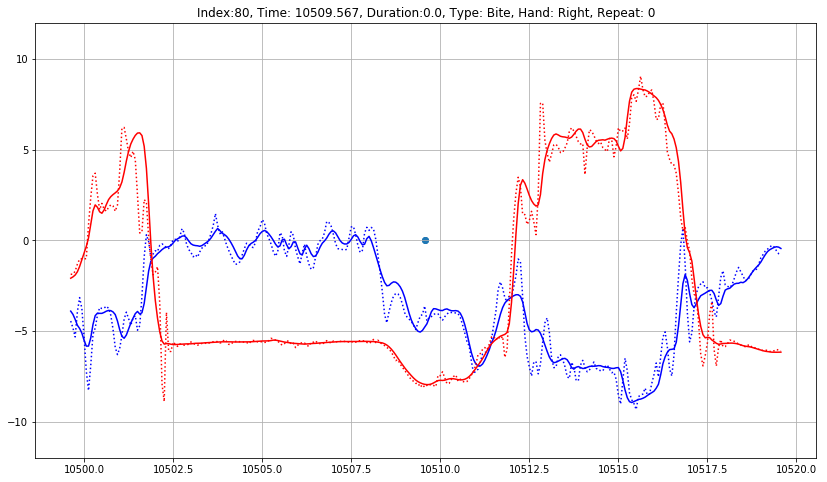

Index:81, Time: 10522.5, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10522.5 0.0
319


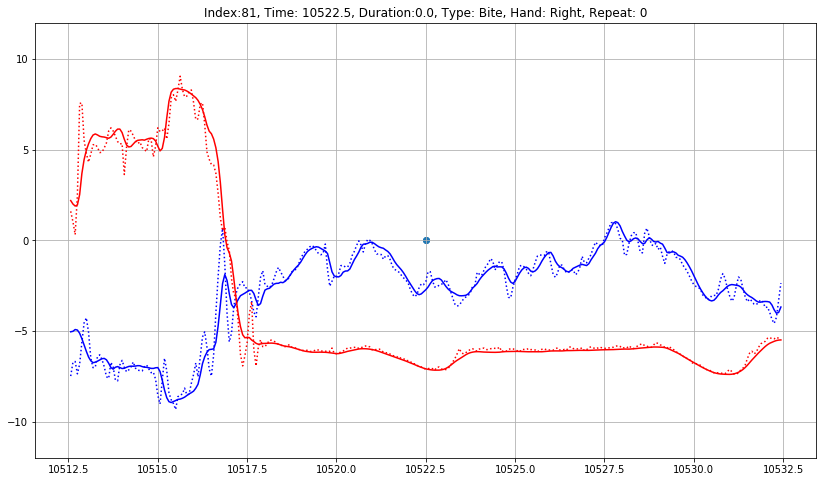

Index:82, Time: 10530.716, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10530.716 0.0
320


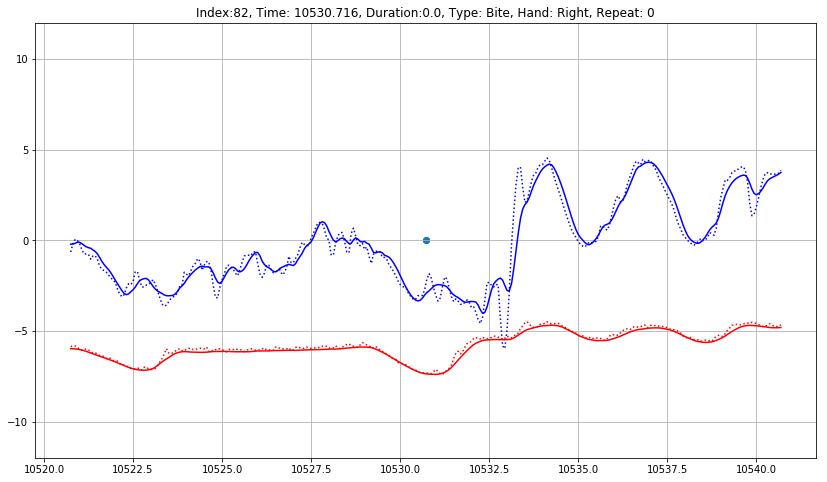

Index:83, Time: 10535.4495, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10535.4495 0.0
320


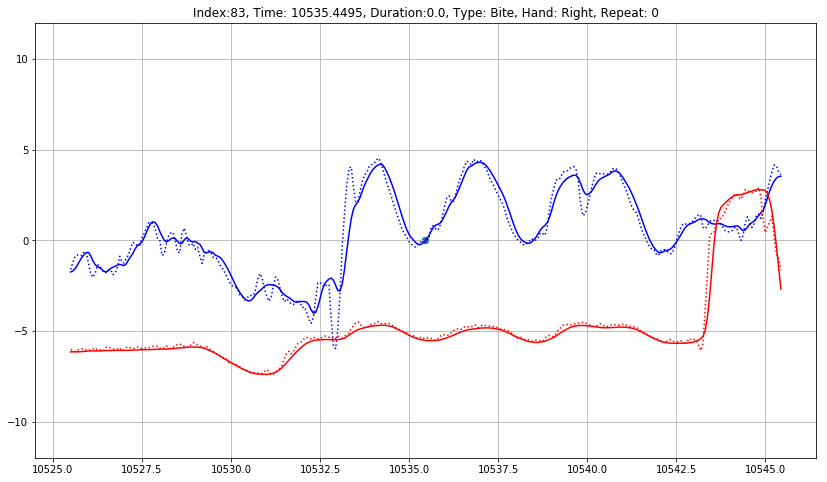

Index:84, Time: 10538.5335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10538.5335 0.0
320


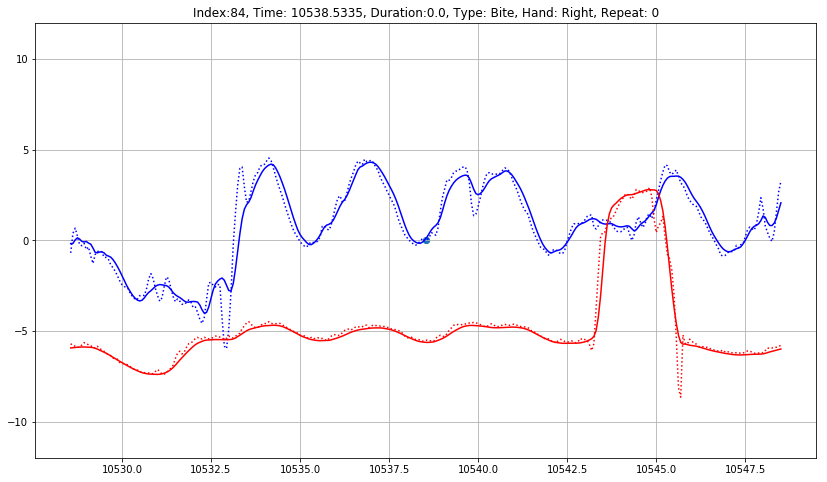

Index:85, Time: 10542.25, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10542.25 0.0
319


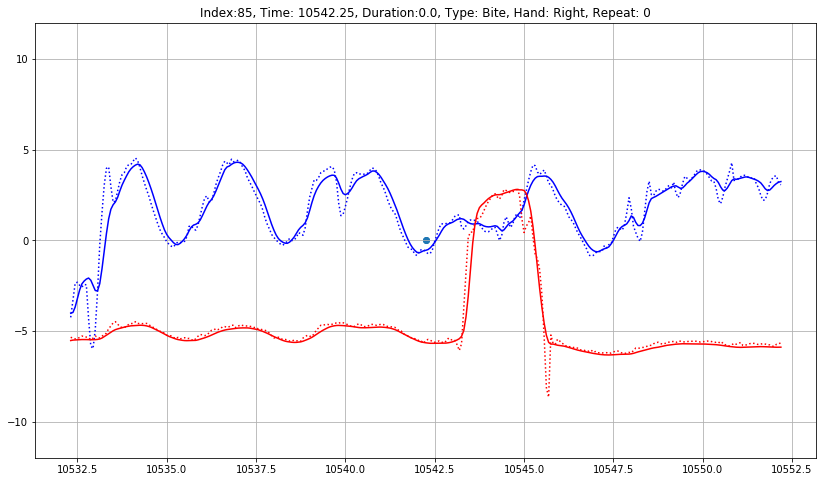

Index:86, Time: 10547.1995, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10547.1995 0.0
320


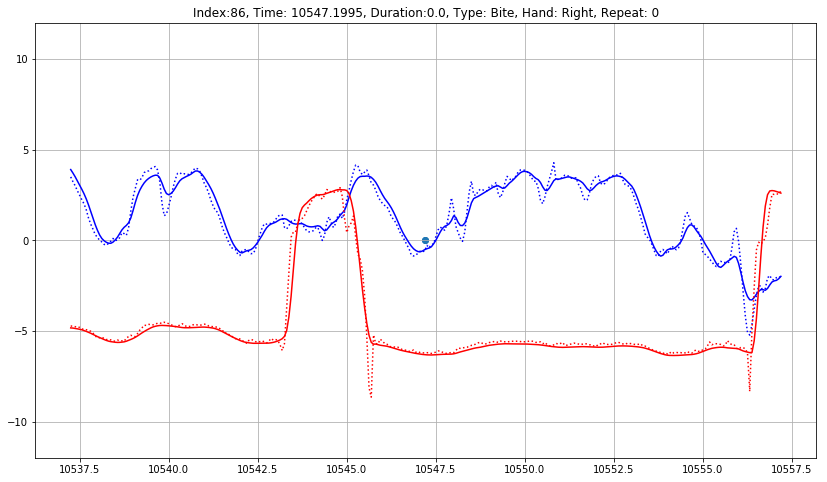

Index:87, Time: 10554.0335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10554.0335 0.0
320


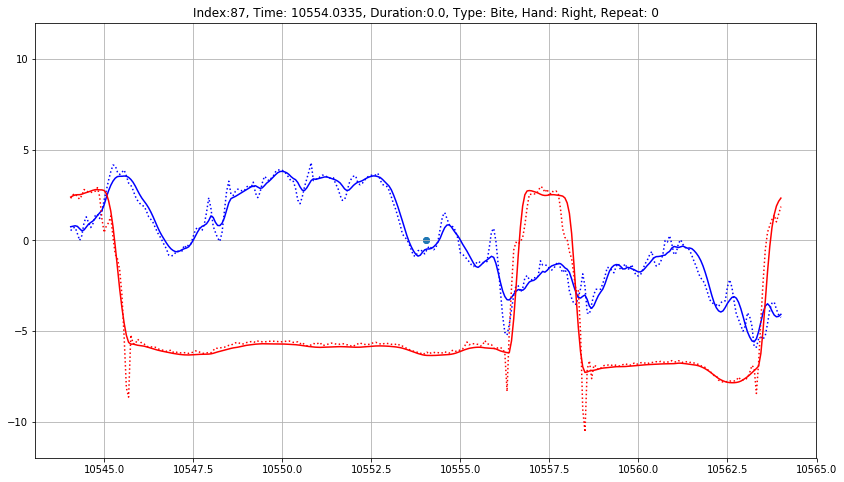

Index:88, Time: 10562.5505, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10562.5505 0.0
320


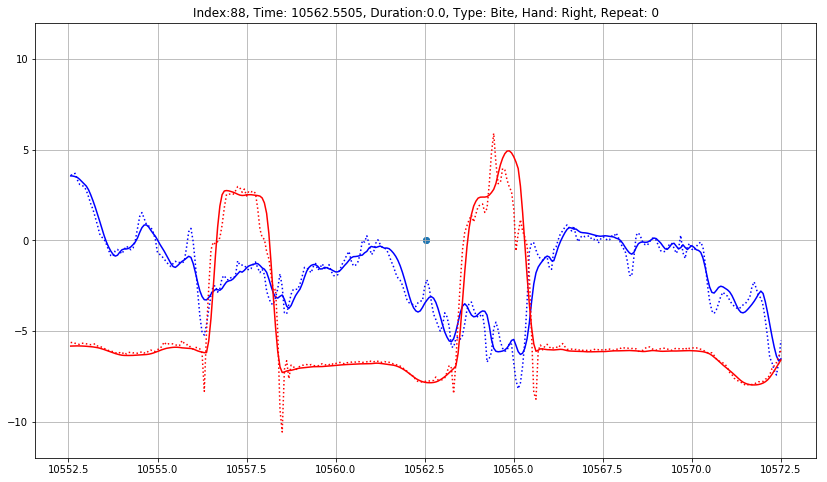

Index:89, Time: 10571.6165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10571.6165 0.0
320


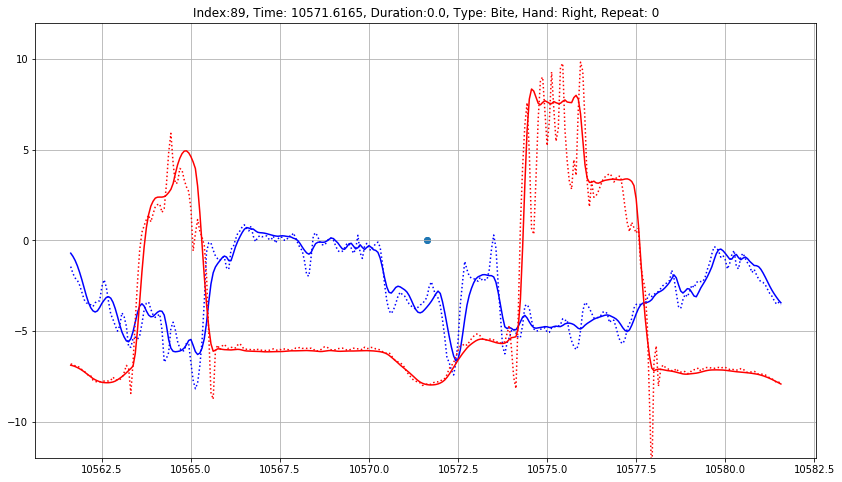

Index:90, Time: 10582.133, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10582.133 0.0
320


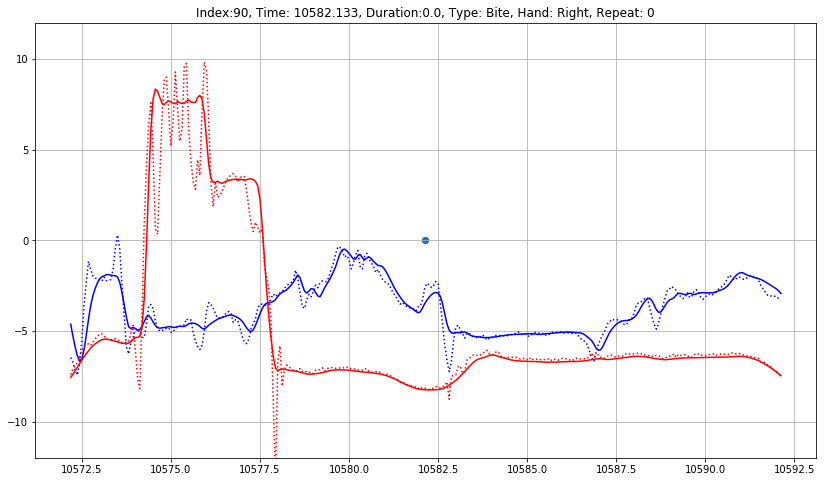

Index:91, Time: 10592.917, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10592.917 0.0
320


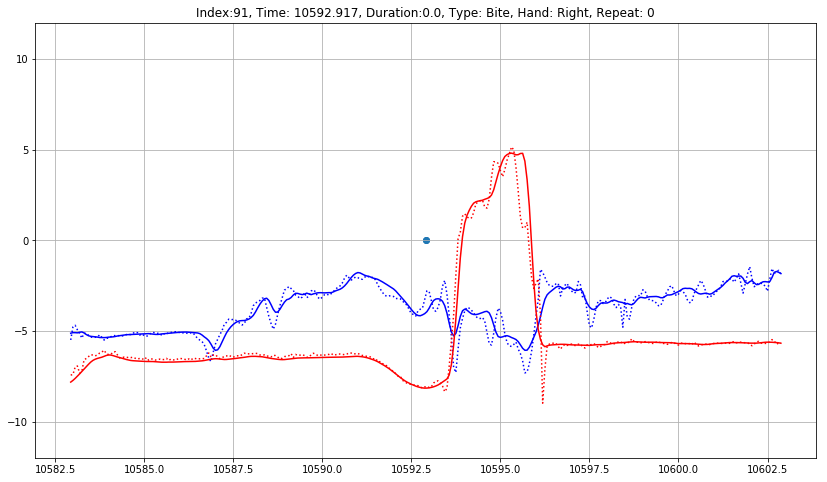

Index:92, Time: 10603.8165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10603.8165 0.0
320


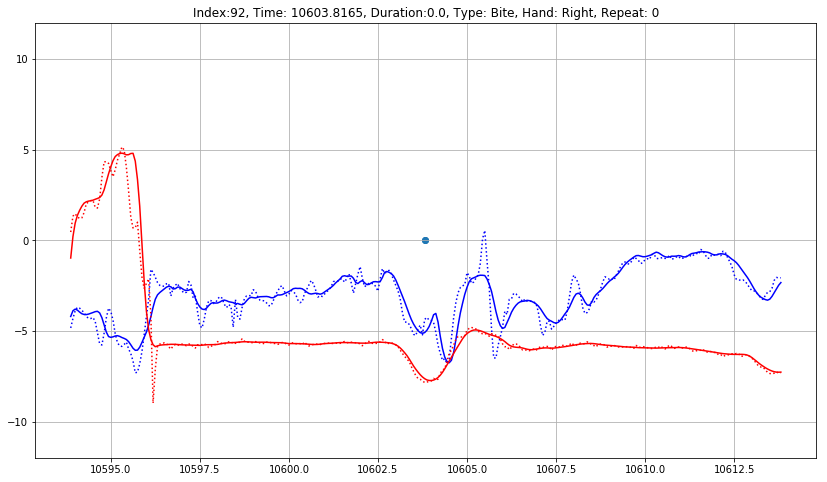

Index:93, Time: 10613.667, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10613.667 0.0
320


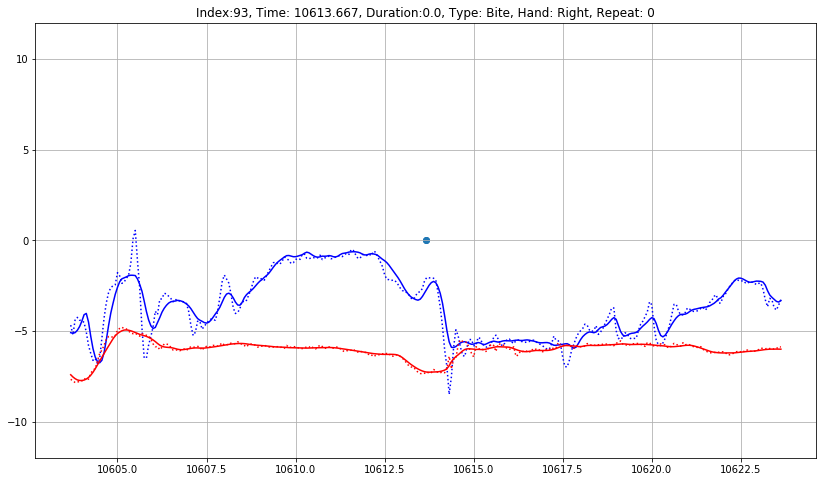

Index:94, Time: 10628.75, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10628.75 0.0
319


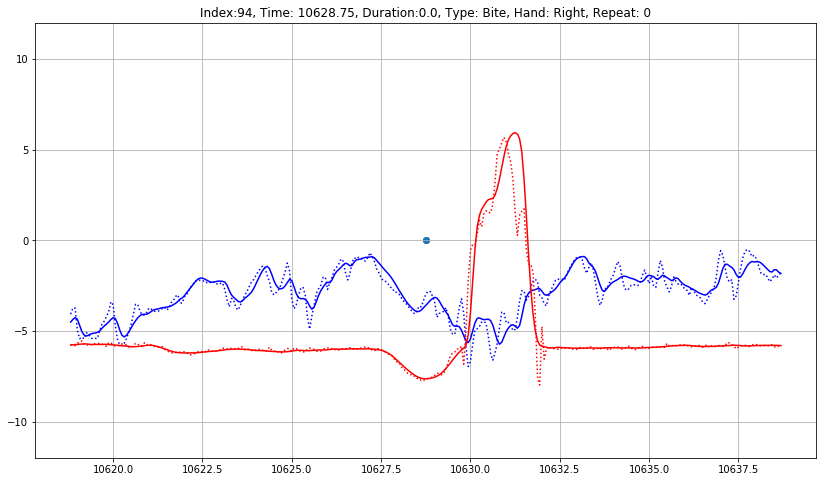

Index:95, Time: 10641.4165, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10641.4165 0.0
320


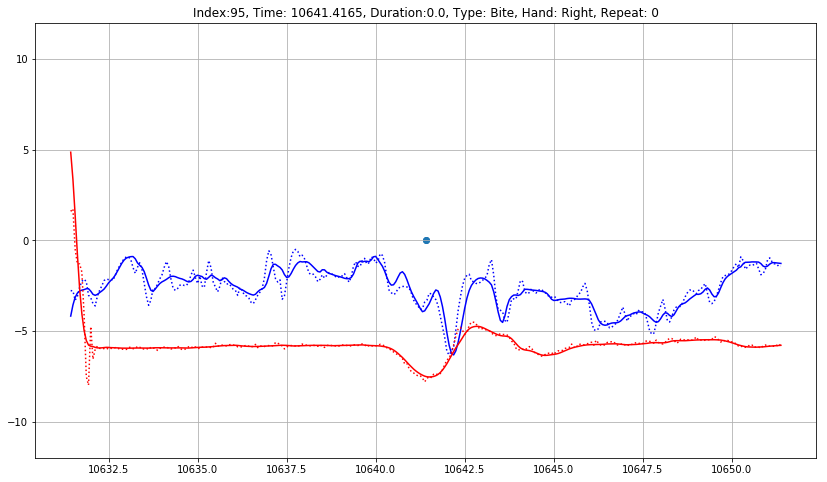

Index:96, Time: 10653.384, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10653.384 0.0
320


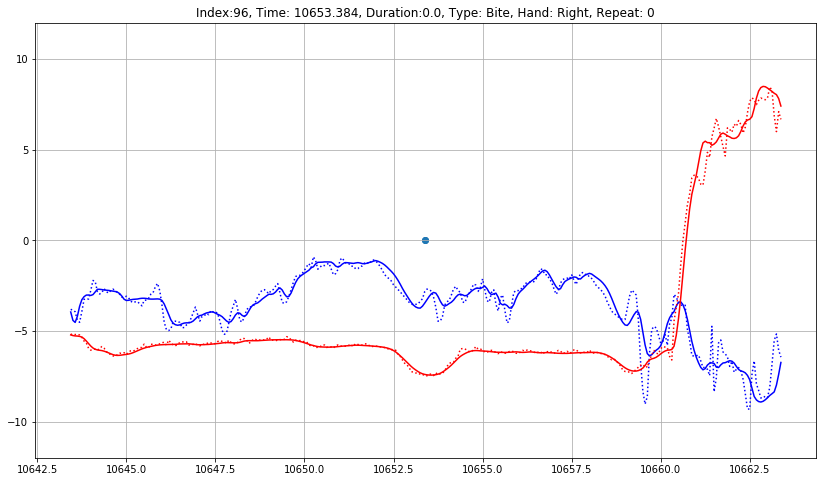

Index:97, Time: 10659.2175, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10659.2175 0.0
320


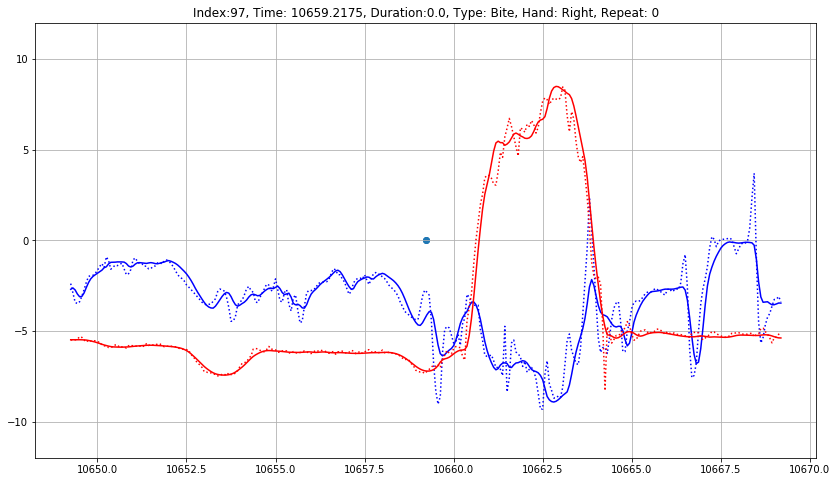

Index:98, Time: 10673.4835, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10673.4835 0.0
320


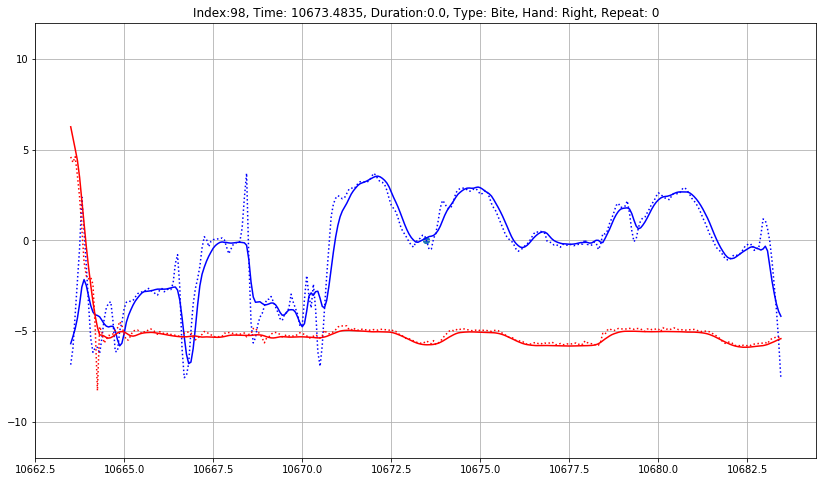

Index:99, Time: 10676.5335, Duration:0.0, Type: Bite, Hand: Right, Repeat: 0
10676.5335 0.0
320


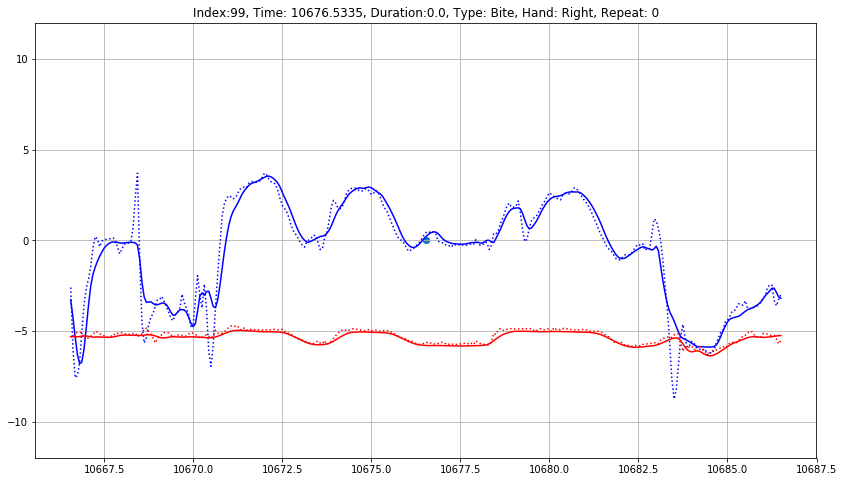

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_title(annots, current_index):
    a = annots[current_index]
    bs, hand = ["", "Bite", "Sip"], ["", "Right", "Left", "Both"]     
    return "Index:{}, Time: {}, Duration:{}, Type: {}, Hand: {}, Repeat: {}".format(current_index, a[0], a[1], bs[int(a[2])], hand[int(a[3])], int(a[4]))

subj, sess = 2, 0
dr = ds[subj][sess]['data_right']
dl = ds[subj][sess]['data_left']
annots = ds[subj][sess]['annots']
print(len(annots))

for current_index in range(0, 100):#, len(annots)):
    print(get_title(annots, current_index))
    
    fig,ax=plt.subplots(figsize=(14,8))
    st = annots[current_index, 0]
    et = annots[current_index, 1]
    
    print(st, et)
    cond = (dr[:,0]>st-10) & (dr[:,0]<st+et+10)
    t = dr[cond, 0]
    print(len(t))
    ax = dr[cond, 1]
    gx = dr[cond, -3]*9.81
    plt.plot(t, ax, linestyle=':', color='blue')    
    plt.plot(t, gx, color='blue')

    cond = (dl[:,0]>st-10) & (dl[:,0]<st+et+10)
    t = dl[cond, 0]
    ax = dl[cond, 1]
    gx = dl[cond, -3]*9.81
    plt.plot(t, ax, linestyle=':', color='red')
    plt.plot(t, gx, color='red')

    plt.scatter([st, st+et], [0, 0])

    plt.ylim([-12, 12])
    plt.grid(True)
    plt.title(get_title(annots, current_index))
    plt.draw() #redraw

    current_index+=1

    #fig.canvas.mpl_connect('button_press_event',onclick)
    plt.show()
    